<font size="6">**B. Gestione delle serie temporali**</font><br>

> (c) 2025 Antonio Piemontese

---

**Legenda icone (standard) usate nel notebook**:<br>
👉 punto di attenzione, il "succo"<br>
📌 nota<br>
📦 punto elenco importante<br>
📊 dati/numeri<br>
🔹 punto elenco normale<br>
⭐ punto elenco importante<br>
✅ punto risolto, positivo<br>
❌ punto negativo, da evitare<br>
⚠️ attenzione

---

# Importazione dei package necessari

In [2]:
from pathlib import Path
import datetime

import pandas as pd               
import matplotlib.pyplot as plt          # per i grafici matplotlib (meglio di 'pylab')


import statsmodels.api as sm             # per stimare modelli statistici 
import statsmodels.formula.api as smf    # per specificare modelli statistici usando una sintassi simile a R, basata su formule
from statsmodels.tsa import tsatools     # funzioni di supporto alla gestione di serie temporali 
import matplotlib.dates as mdates        # sottomodulo che gestisce le date sugli assi dei grafici
import patsy                             # libreria per scrivere formule di regressione in stile R (usata automaticamente 
                                         # anche da statsmodels.formula.api)      

import math
import numpy as np 

%matplotlib inline

In [3]:
# il package 'dmba' contiene diverse utilità; è presente nel PPI (Python Package Index) e può quindi essere installato
# con il comando: 'pip install dmba' (da anaconda prompt) 
import dmba                          # la load in memoria dopo l'install 
from dmba import regressionSummary   # un'utile sintesi degli output del metodo di regressione


Il codice del package 'dmba' è pubblico e mantenuto dall'autore a [questo link github](https://github.com/gedeck/dmba).

# Cos'è la gestione delle serie storiche (temporali)

## Cosa sono i *cross-sectional data*
Le tecniche di ML si occupano normalmente di **dati cross-sezionali** (*cross-sectional data = dati trasversali*), cioè dati **allo stesso periodo di tempo**, ad esempio l'anagrafica clienti o  l'anagrafica prodotti al tempo t0.

Nella gestione delle serie storiche, invece, **il tempo** è un fattore trattato in modo <u>differente</u> dalle altre variabili.
Si parla di analisi **longitudinale**.

In statistica ed econometria ci sono **3 tipi di dati principali**:
- dati cross-sezionali
- time series
- panel data 

Ecco le differenze:

![](3_tipi_dati_statistici.png)

---

Di per sè, una colonna "tempo" (es. data/ora) può esserci in tutti i dataset, e non per questo si parla di serie storiche. In queste ultime **il "tempo" gioca un ruolo chiave e la colonna "data/ora" è la chiave del dataset**, quella rispetto alla quale si fanno ordinamenti oppure slicing (cioè estrazione di sottoinsiemi).

---

**Confronto tra dati cross-sezionali e time series**<br>
![](CS_vs_TS.png)

## Gestione delle serie storiche

**Due tipi** di "gestione" delle serie storiche: 
* **Analisi** delle serie temporali (o storiche), riferita al <u>passato</u> (detta spesso **TSA** = Time Series Analysis), anche sino a ieri
* **Forecasting**, riferito al <u>futuro</u> (detta spesso **TSF** = Time Series Forecasting), da domani in poi (per un determinato **orizzonte temporale** di previsisone).

TSA individua **trend, relazioni, pattern stagionali e fattori esterni (driver)** della serie storica.
Il forecasting (TSF) invece prevede i **valori FUTURI** della serie storica. [nb. Forecasting <> Prediction].

> TSA è Machine Learning **descrittivo** (od esplorativo), TSF è Machine Learning **predittivo**.

I metodi (**gli algoritmi**) di ML che si usano per TSA sono quindi diversi da quelli che si usano per il TSF.
I metodi di TSA, infatti, cercano di <u>capire e spiegare</u>; quelli di TSF sono spesso <u>"black box"</u> (ci interessa la affidabilità delle previsioni, non come questa avvenga).<br>
I metodi di TSA, inoltre, sono retrospettivi (guardano al passato), quelli di TSF sono prospettici (guardano al futuro).
--> in questo corso vedremo **esempi sia di TSA che di TSF**.

In questo corso tratteremo <u>le serie storiche "singole"</u>, le più comuni e semplici. Esempi di serie storicche **multiple**: le vendite mensili di diversi prodotti INSIEME, oppure la storia degli ordini e ricavi INSIEME, oppure i prezzi azionarie di alcuni titolo INSIEME.<br>
Le serie storiche singole NON gestiscono le possibili interazioni, nel senso che o la serie è singola (non possono esserci interazioni) oppure l'analisi è fatta in modo indipendente per ogni colonna, senza considerare le possibili interazioni tra colonne; la gestione di queste interazioni, tuttavia, richiede assunzioni restrittive e competenze statistiche più avanzate. Vedi il corso sui big data che utilizza serie storiche multiple azionarie di tipo OHLCV.

---

In questo notebook useremo `pandas` per la gestione dei dati, `matplotlib` per la visualizzazione e `statsmodels` per la costruzione dei modelli.

---

# Le componenti di una serie storica
Una serie storica ha **6 possibili componenti**:
* lo <u>step o periodo</u>: la settimana, il giorno, l'ora, ecc delle osservazioni;
* il <u>livello medio</u> della serie (ad es. la quantità media di prodotto venduta, il numero medio di passeggeri, ecc);
* il <u>trend</u>: come la serie cambia nel tempo; ad esempio: cresce nel tempo, oppure diminuisce, in modo lineare oppure no, ecc;
* la <u>stagionalità</u>: gli eventuali comportamenti **ciclici** (all'interno dell'intervallo temporale ossevato): non è necessariamente la stagione dell'anno.<br>
    Nei mercati finanziari la stagionalità è in genere più debole ed irregolare che nelle vendite, turismo, trasporti, ma comunque spesso presente (ad es. *day-of-the-week effect*: rendimenti medi più bassi il lunedì; *january effect*: storicamente rendimenti più alti a gennaio; picchi intraday: volatilità maggiore in apertura/chiusura dei mercati).
* il <u>rumore</u> (*noise*): la variazione casuale (per errori di misurazione/rilevamento del fenomeno, altri fattori non considerati, oppure la vera e propria casualità). E' sempre presente, in qualche misura ([esempio con scala differente](componenti_TS.png));
* l'<u>auto-correlazione</u>: i valori della serie sono auto-correlati quando valori alti sono insieme agli alti (e viceversa per i valori bassi). Esempi tipici di serie auto-correlate: l'inquinamento atmosferico nelle varie giornate, i prezzi azionari, i tempi di attesa dei vari clienti in una coda di uno sportello bancario (o di una seggiovia).

Il livello, il trend e la stagionalità sono "invisibili", poichè caratterizzano la serie storica **sottostante**, che noi possiamo osservare solo con il rumore aggiunto.<br>
Vediamole ora <u>le prime tre componenti</u> con maggior dettaglio. Le altre saranno approfondite più avanti.

## Lo step o periodo
Sono anche detti *granularità* o *frequenza* (la frequenza con cui viene campionato o misurato un dato punto della serie.). Possono essere aggregati.<br>
![](granularità.png)

In azzurro si vede la serie giornaliera (granularità alta, molto dettagliata ma anche più rumorosa), in arancione la stessa serie aggregata su base mensile (granularità più bassa, curva più “liscia”). Questo mostra come la scelta della granularità **influisce sulla rappresentazione e sulle analisi** che si possono fare.

**Esempi pratici**:

- **Alta granularità** → dati molto frequenti
    - Millisecondi (log di un server, trading ad alta frequenza)
    - Secondi (sensori IoT, battito cardiaco)
    - Minuti (dati di borsa, temperatura meteo a breve termine)
<br><br>
- **Bassa granularità** → dati più aggregati
    - Giorni (vendite giornaliere di un negozio)
    - Mesi (bollette, fatturato mensile)
    - Anni (PIL, dati demografici)
  
Una serie con granularità giornaliera può essere **aggregata** a livello settimanale o mensile (per analisi macro).<br>
La scelta della granularità **influisce** su:
- la stazionarietà (un dataset ad alta granularità può sembrare rumoroso, uno a bassa granularità più “liscio”)
- i modelli applicabili (ad es. ARIMA giornaliero ≠ ARIMA mensile)
- la precisione delle previsioni (più dettaglio = più variabilità).

## Il livello medio della serie
Il livello è uno dei componenti fondamentali insieme a trend e stagionalità, anche se è meno "tecnico".<br>
È **la “base” della serie**. Se si pensa al trend come alla direzione di fondo (in salita, in discesa), il livello è **l’altezza media** della serie.<br>
Nei modelli lineari è rappresentato dal termine $\beta_0$.<br>
Nei modelli dinamici (*smoothing*) rappresenta la “base” della serie a quel tempo 𝑡.


## Il trend
Il trend in una serie temporale è la componente di **lungo periodo** che descrive la **tendenza generale dei dati nel tempo**, <u>al netto delle fluttuazioni casuali o stagionali</u>.<br>
In altre parole: è la “direzione di fondo” della serie.

📌 Caratteristiche del trend
- può essere crescente (es. PIL in crescita),
- decrescente (es. vendite di DVD negli anni),
- o stazionario (nessuna tendenza evidente).
- può essere lineare (aumento costante) o non lineare (curvo, esponenziale, logistico).

📌 Esempio semplice
- Si immagini la serie del prezzo medio di case in una città:
- Giorno per giorno i prezzi oscillano (rumore, stagionalità).
- Ma guardando 10 anni, spesso si vede un andamento in crescita costante.<br>
👉 Quello è il trend.

📌 Importanza
- Identificare il trend serve per distinguere variazioni di lungo periodo da quelle di breve periodo (stagionali o casuali).
- Nei modelli come ARIMA, il trend è legato alla non stazionarietà (spesso bisogna “differenziare” la serie per rimuoverlo).
- In decomposizione classica (seasonal_decompose), la serie viene spezzata in:
    - Trend
    - Stagionalità
    - Residuo

---
[Trend vs Pattern](https://www.investopedia.com/ask/answers/010715/what-are-differences-between-patterns-and-trends.asp):<br>
*A trend is the **general direction** of a price/quantity over a period of time. A pattern is a set of data that follows **a recognizable form**
(*regularity*), which analysts then attempt to find in the current data.*

---

---
Nei modelli regressivi lineari, il trend lineare coincide con lo slope $\beta_1$ del modello.<br>
In modelli ARIMA, ETS, ecc., il trend viene modellato diversamente (non è un coefficiente unico, ma una componente che evolve nel tempo).

---

## La decomposizione delle componenti principali

**Esempio di serie temporale con suddivisione in tempo, stagionalità e rumore**, fatta con `seasonal_decompose` di `statsmodels:` (vedi più avanti):<br>
![](confronto_componenti.png)

# Il dataset

Useremo la serie temporale di [**Amtrak**](https://www.amtrak.com/home). Amtrak è una compagnia ferroviaria americana, colleziona con regolarità i dati relativi ai passeggeri (`ridership`). Il periodo collezionato è **GEN91 - MAR04** (**159 mesi**, quasi 14 anni). 

E' dunque una serie MENSILE (cioè, lo step o periodo è il mese). Il dataset è **pubblico**, vedi ad esempio [qui](https://www.kaggle.com/datasets/nirmalnk/amtrak-timeseries) (in forma già elaborata con alcune colonne in più, noi useremo invece una versione del dataset più grezza).

> La serie *Amtrak* è **ottima per imparare** perchè è breve, esibisce trend e stagionalità, i lag 6 e 12 sono autocorrelati con il lag0 (vedi il plot della ACF nel notebook *C. Forecasting delle TS con la Regressione*)

Lo scopo del TSF sarà di prevedere i passeggeri dei primi mesi fuori serie, cioè: **APR04, MAG04, ecc**.

In [4]:
Amtrak_df = pd.read_csv('Amtrak.csv') 

# Amtrak_df = dmba.load_data('Amtrak.csv') # alternativa

display(Amtrak_df,'\n')        # --> i dati sono ora organizzati in modo matriciale: per anno (stagione) e per mese (la frequenza).
                               #     '\n' aggiunge solo una linea vuota per separare i diversi output delle 'print'.
display(Amtrak_df.info())      # --> 'Month' è una stringa ('object') [attenzione: sono tutti oggetti Python!]

,Month,Ridership
0,01/01/1991,1708.917
1,01/02/1991,1620.586
2,01/03/1991,1972.715
3,01/04/1991,1811.665
4,01/05/1991,1974.964
...,...,...
154,01/11/2003,2076.054
155,01/12/2003,2140.677
156,01/01/2004,1831.508
157,01/02/2004,1838.006


'\n'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      159 non-null    object 
 1   Ridership  159 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB


None

In [5]:
type(Amtrak_df)   # la classe

pandas.core.frame.DataFrame

# La trasformazione dei dati

Prima di fare TSA / TSF il dataframe della serie (nel nostro caso `Amtrak_df`) deve essere **trasformato** in tre modi:
- la <u>conversione della data</u> (l'elemento chiave) da stringa (un *object* in pandas), che NON è facilmente manipolabile, a *datetime64* (un altro tipo dato in pandas) con formato che invece è **manipolabile**. In realtà, qui AGGIUNGIAMO una nuova colonna di tipo *datetime*, mantenendo la vecchia.
- la creazione di un <u>oggetto pandas di tipo *Series*</u> con la nuova colonna come indice</u>
- la creazione di un <u>nuovo indice</u> **con frequenza inferita**

Vediamo la **prima** trasformazione.

In [6]:
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df['Month'], format='%d/%m/%Y')
display(Amtrak_df.head())
Amtrak_df.dtypes

,Month,Ridership,Date
0,01/01/1991,1708.917,1991-01-01
1,01/02/1991,1620.586,1991-02-01
2,01/03/1991,1972.715,1991-03-01
3,01/04/1991,1811.665,1991-04-01
4,01/05/1991,1974.964,1991-05-01


Month                object
Ridership           float64
Date         datetime64[ns]
dtype: object

La **seconda** trasformazione: convertiamo la colonna dei VALORI della serie in un oggetto pandas *Series* (l'argomento `name` è usato per dare un nome alla serie) e creiamo un nuovo indice sulla colonna `date` (creata prima):

In [7]:
ridership_ts = pd.Series(Amtrak_df['Ridership'].values, index=Amtrak_df['Date'], name='Ridership')

display(ridership_ts.head())
print("\n", type(ridership_ts),"\n")
ridership_ts.info()

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
Name: Ridership, dtype: float64


 <class 'pandas.core.series.Series'> 

<class 'pandas.core.series.Series'>
DatetimeIndex: 159 entries, 1991-01-01 to 2004-03-01
Series name: Ridership
Non-Null Count  Dtype  
--------------  -----  
159 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


Attenzione: il data type *Series* di pandas è un generico VETTORE di elementi numerici (come può  esserlo anche una colonna di un dataframe) e NON rappresenta necesariamente una serie temporale (time series).

Come **terza** trasformazione **inferiamo la frequenza** della serie dall'indice della serie (la frequenza di base, qui mensile) e incorporiamola in un **nuovo indice**.<br>
Si noti che questo è un altro modo per rilevare l'eventuale mancanza di mesi nella serie. Se infatti, nella cella seguente, usiamo  gli oggetti precedenti (`ridership_ts_MV`) il codice funziona ma la *freq* rilevata e visualizzata in basso è *None*.

In [8]:
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)
ridership_ts.index

DatetimeIndex(['1991-01-01', '1991-02-01', '1991-03-01', '1991-04-01',
               '1991-05-01', '1991-06-01', '1991-07-01', '1991-08-01',
               '1991-09-01', '1991-10-01',
               ...
               '2003-06-01', '2003-07-01', '2003-08-01', '2003-09-01',
               '2003-10-01', '2003-11-01', '2003-12-01', '2004-01-01',
               '2004-02-01', '2004-03-01'],
              dtype='datetime64[ns]', name='Date', length=159, freq='MS')

Spieghiamo meglio la precedente trasformazione:

```python
pd.DatetimeIndex(ridership_ts.index, ...)
```
    - Ricostruisce l’indice della serie `ridership_ts` come un `DatetimeIndex` (oggetto pandas dedicato alle date).
    - Serve per assicurarsi che l’indice sia effettivamente trattato come serie temporale.
```python
ridership_ts.index.inferred_freq
```
    - Pandas cerca di indovinare la frequenza della serie temporale analizzando la spaziatura tra le date (giornaliera, mensile, settimanale, ecc.).
    - Se riconosce una frequenza costante, restituisce una stringa tipo "D", "M", "W", "H".
    - Se non riesce a dedurre una frequenza → restituisce None.

```python
freq=... dentro DatetimeIndex
```
    - Imposta esplicitamente l’attributo `freq` dell’indice (cioè la frequenza temporale dei dati).
    - Questo è utile perché molti modelli di forecasting in `statsmodels` o `pandas` richiedono che l’indice abbia una freq definita (non `None`).

In [9]:
ridership_ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 159 entries, 1991-01-01 to 2004-03-01
Freq: MS
Series name: Ridership
Non-Null Count  Dtype  
--------------  -----  
159 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


# I valori mancanti

E' utile una <u>verifica preliminare</u> sulla eventuale presenza nella serie temporale di **buchi**, cioè, in questo caso, mesi **mancanti**. Si procede in questo modo (con il dataset *Amtrak*):

In [10]:
diffs = ridership_ts.index.to_series().diff().value_counts()  # 3 metodi pandas in cascata
print(diffs)

Date
31 days    92
30 days    52
28 days    10
29 days     4
Name: count, dtype: int64


Come si vede, il totale dei mesi è correttamente 159. Cosa sarebbe successo in caso di mesi mancanti?<br>
Utilizziamo a questo scopo il dataset `Amtrak_with_MV` nel quale mancano i mesi 3-94, 10-99 e 5-03 e rieseguiamo il codice con questo nuovo file csv.

In [11]:
Amtrak_df_MV = pd.read_csv('Amtrak_with_MV.csv')
Amtrak_df_MV['Date'] = pd.to_datetime(Amtrak_df_MV['Month'], format='%d/%m/%Y')
ridership_ts_MV = pd.Series(Amtrak_df_MV['Ridership'].values, index=Amtrak_df_MV['Date'], name='Ridership')
diffs_MV = ridership_ts_MV.index.to_series().diff().value_counts() 
print(diffs_MV)

Date
31 days    89
30 days    50
28 days     9
29 days     4
61 days     2
59 days     1
Name: count, dtype: int64


Risultano 2 mesi di 61 giorni ed 1 mese di 59, ad indicare la mancanza di alcune elementi della serie. Quali sono? Sarebbe da approfondire.

Torniamo al file CSV originale e alla serie completa `ridership_ts` (senza `_MV`):

# Il line plot

Per prima cosa, dopo la trasformazione dei dati, si **identificano visivamente le componenti** di una serie temporale tramite il **plot della serie** (completa), detto ***line plot*** oppure *line chart* oppure ancora *grafico a linea* in italiano.<br>
E' un plot dei valori della serie nel tempo, con le etichette temporali in ascissa.<br>
Lo facciamo con il package *matplotlib* che ha una sua sintassi e costruisce il plot poco per volta:

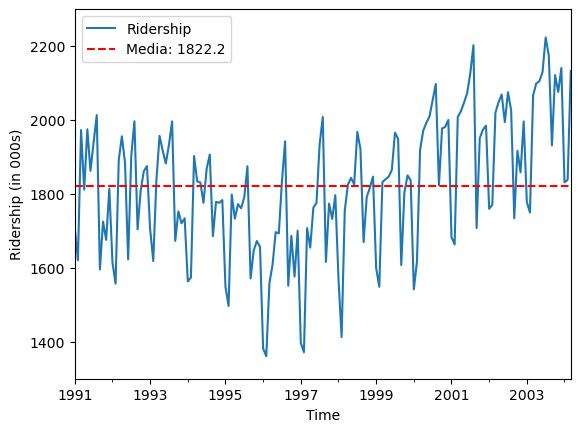

In [12]:
ax = ridership_ts.plot()
ax.set_xlabel('Time')
# ax.set_yscale('log')  # [se si vuole la y logaritmica]
ax.set_ylabel('Ridership (in 000s)')
_ = ax.set_ylim(1300, 2300)

# Aggiunta della linea orizzontale al valore medio
media = ridership_ts.mean()
ax.axhline(y=media, color='red', linestyle='--', label=f'Media: {media:.1f}')
ax.legend()

plt.show()


Il **livello** (la media generale della serie) sembra intorno a 1.800K al mese.<br>
C'è una leggera forma generale ad U (**U-shape**), con una pronunciata stagionalità annuale, con picco dei viaggi in estate (luglio ed agosto) - NON ancora ben visibile da questo plot.<br>
Attenzione: gli indici temporali della serie (in ascissa) sono per definizione DISCRETI. La serie appare come CONTINUA solo perchè il line chart per comodità collega tutti i valori della serie con una linea. 

In [13]:
ridership_ts.mean().item()     # la media aritemetica della serie
                               # il metodo '.item()' serve ad estrarre solo il valore e non anche il data-type

1822.1972075471697

In [14]:
ridership_ts.median()          # la mediana, cioè il valore della serie rispetto al quale il 50% degli altri valori è superiore
                               # e l'altro 50% è inferiore.

1831.049

In [15]:
ridership_ts.std()             # la deviazione standard della serie

181.63603371201944

Per comodità possiamo **arrotondare** i valori di queste tre metriche (a due decimali) con la funzione di *numpy* `np.round()`:

In [16]:
display(round(ridership_ts.mean().item(),2))
display(round(ridership_ts.median(),2))
display(round(ridership_ts.std(),2))

1822.2

1831.05

181.64

# Tecniche grafiche
Per <u>esaminare più attentamente</u> una serie storica (in modo grafico) sono molto utili questi strumenti:
* **zoom**: particolarmente utile con serie lunghe: può infatti rivelare pattern locali prima nascosti (vedi prossime celle);
* **cambio di scala**: ad es. il logaritmo per linearizzare / compattare un [andamento esponenziale](https://it.wikipedia.org/wiki/Funzione_esponenziale) [in *matplotlib* si usa *ax.set_yscale('log')*]; se il trend nella nuova scala sembra più o meno lineare significa allora che il trend nella vecchia scala è circa esponenziale ([esempio nella terza sezione](https://www.graphpad.com/guides/prism/latest/user-guide/when_to_use_a_logarithmic_axis.htm)); attenzione a [questa differenza](https://www.researchgate.net/figure/Comparison-of-exponential-and-logistic-growth_fig4_262891745), ad esempio nella diffusione pandemica;
* **sovrapposizione della linea di trend (ai dati "grezzi" della serie, *raw data*)**: è un'altra possibilità per meglio individuare l'andamento indicativo della serie, quello che meglio si adatta (*fitting*) ai dati ([vedi qui](Shapes.png) ed anche [questa voce di Wikipedia](https://it.wikipedia.org/wiki/Curve_fitting));
* **soppressione della stagionalità**, ad es. a) aggregando i dati, oppure b) creando serie/plot differenti per ogni stagionalità, oppure c) ancora usando un diagramma a media mobile (lo vedremo più avanti); la soppressione della stagionalità spesso aiuta ad identificare meglio gli eventuali trend / pattern della serie;
 
Sospendiamo un attimo l'analisi di *Amtrak* (che non ha la granularità sufficiente per fare zoom) ed utilizziamo un altro dataset più adatto per questa dimostrazione (**con granularità giornaliera**);<br>
Sono i passaggi GIORNALIERI sotto il tunnel svizzero di [**Baregg**](https://en.wikipedia.org/wiki/Baregg_Tunnel).<br>
Qui lo step o periodo è il **giorno**.

In [17]:
# l'esame del dataset
baregg_df = dmba.load_data('BareggTunnel.csv') # import con la utility di 'dmba', questa volta
print(baregg_df.shape,'\n')
print(type(baregg_df),'\n')
print(baregg_df,'\n')
print(baregg_df.info(),'\n') # --> è una stringa

(747, 2) 

<class 'pandas.core.frame.DataFrame'> 

             Day  Number of vehicles
0    01 Nov 2003              103536
1    02 Nov 2003               92051
2    03 Nov 2003              100795
3    04 Nov 2003              102352
4    05 Nov 2003              106569
..           ...                 ...
742  12 Nov 2005              104646
743  13 Nov 2005               94424
744  14 Nov 2005              112165
745  15 Nov 2005              114296
746  16 Nov 2005              114690

[747 rows x 2 columns] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Day                 747 non-null    object
 1   Number of vehicles  747 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB
None 



Come prima per *Amtrak* eseguiamo anche qui un paio di trasformazioni preliminari:

In [18]:
# conversione della data da oggetto stringa ('object data type') ad oggetto 'datetime':
baregg_df['Date'] = pd.to_datetime(baregg_df.Day, format='%d %b %Y')

# creazione della serie PIENA dei VALORI (senza visualizzazione):
vehicles_ts = pd.Series(baregg_df['Number of vehicles'].values, index=baregg_df['Date'], name='Vehicles')

In [19]:
baregg_df.dtypes

Day                           object
Number of vehicles             int64
Date                  datetime64[ns]
dtype: object

In [20]:
vehicles_ts

Date
2003-11-01    103536
2003-11-02     92051
2003-11-03    100795
2003-11-04    102352
2003-11-05    106569
               ...  
2005-11-12    104646
2005-11-13     94424
2005-11-14    112165
2005-11-15    114296
2005-11-16    114690
Name: Vehicles, Length: 747, dtype: int64

In [21]:
vehicles_ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 747 entries, 2003-11-01 to 2005-11-16
Series name: Vehicles
Non-Null Count  Dtype
--------------  -----
747 non-null    int64
dtypes: int64(1)
memory usage: 11.7 KB


Come detto, un tipico secondo passo, dopo il line-chart generale, è lo ZOOM.<br>
Creiamo una serie PIU' RISTRETTA di questo dataset (zooming-in), sempre con il package *matplotlib*: una sotto-serie di 4 mesi:

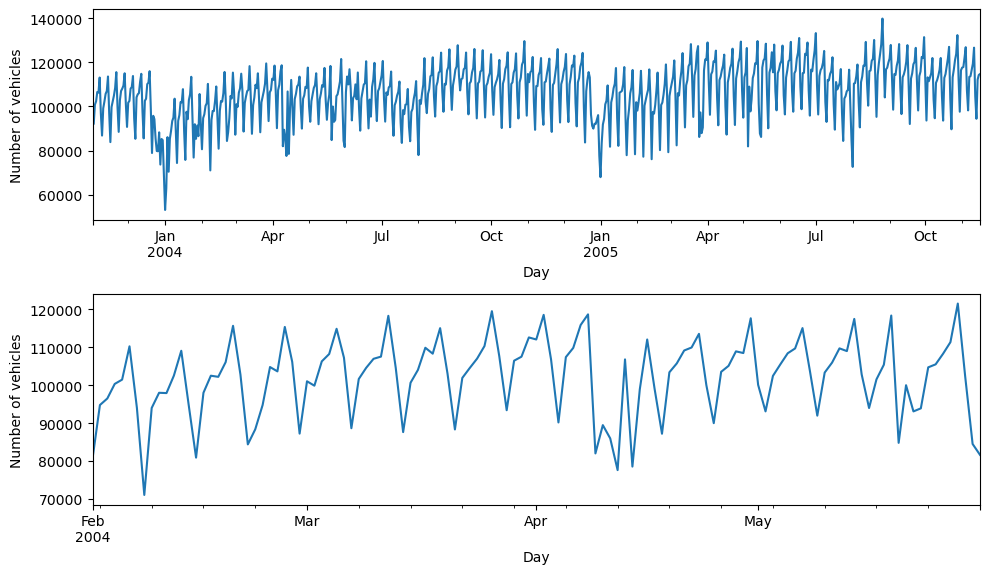

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6)) # 2 sottoplot

     # 'fig, ax' è molto frequente in matplotlib.
     # da stackoverflow (post 34162443): "plt.subplots() is a function that returns a tuple containing a 
     # figure and axes object(s). Thus when using:
     #     'fig, ax = plt.subplots()'
     # you unpack this tuple into the variables 'fig' and 'ax'. Having 'fig' is useful if you want to change
     # figure-level attributes or save the figure as an image file later, e.g. with:
     #     'fig.savefig('yourfilename.png'). 
     # You maybe don't have to use the returned figure object but many people do use it later so it's common
     # to see it. 
     # Also, all axes objects (the objects that have plotting methods), have a parent figure object anyway, 
     # thus: 
     #     'fig, ax = plt.subplots()' 
     # is more concise than: 
     #     'fig = plt.figure()'
     #     'ax = fig.add_subplot(111)
     # If you want 4 graphs, you could have ax11, ax12, ax21, ax22 by using:
     #     'fig.add_subplot(221)'
     # or 222, 223, 224 respectively.


vehicles_ts.plot(ax=axes[0])
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Number of vehicles')
vehicles_ts['2004-02-01':'2004-05-31'].plot(ax=axes[1]) # <-- la serie ristretta di 4 mesi
                                                        #     importante tecnica di subsetting di serie temporali
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Number of vehicles')
plt.suptitle('')    # Suppress the overall title
plt.tight_layout()  # Increase the separation between the plots

plt.show() # --> si nota nello zoom (secondo plot) un chiaro pattern sul giorno della settimana, non visibile sul chart
           #     generale (dei 2 anni).

Risulta qui evidente che nei giorni del fine settimana c'è una forte diminuzione dei passaggi.

# Tipologie e caretteristiche dei modelli di Machine Learning

Prima di fare il fit di un modello sulla serie dati facciamo alcune **considerazioni generali sui modelli di ML**:
* metodi <u>parametrici</u> (diretti): fanno delle **assunzioni sulle componenti** della serie, ad esempio che il trend in un certo periodo è lineare oppure quadratico od esponenziale; oppure che il rumore è [gaussiano](https://en.wikipedia.org/wiki/Gaussian_noise#:~:text=Gaussian%20noise%2C%20named%20after%20Carl,take%20on%20are%20Gaussian%2Ddistributed.);
* i metodi parametrici funzionano molto bene se le assunzioni sono (abbastanza) vere;
* altrimenti si usano metodi <u>non-parametrici</u>, anche detti *distribution-free* oppure *data-driven*, che fanno meno assunzioni sulla struttura delle componenti della serie;
* i metodi non-parametrici sono utili appunto quando le assunzioni probabilmente non sono soddisfatte oppure quando <u>il comportamento della serie cambia nel tempo</u>; sono inoltre semplici e computazionalmente veloci, tuttavia richiedono molti dati;
* un **criterio importante** per decidere **quale tipo di metodo di forecasting** usare è la presenza di <u>pattern globali</u> (cioè che sono abbastanza costanti su tutta la serie) oppure [locali](https://www.researchgate.net/figure/A-shapelet-red-dotted-line-capturing-a-local-pattern-of-a-time-series-blue-solid_fig2_331532370), che cioè avvengono solo in un breve periodo della serie; 
* se i pattern della serie sono globali, i metodi parametrici sono preferibili perchè usano tutti i dati disponibili;
* se i pattern sono locali, al contrario, il metodo parametrico dovrebbe essere applicato ad ogni differente sottosezione della serie, che non è pratico e spesso non noto;
* attenzione: non confondere i pattern locali con [le sotto-popolazioni](Patterns.png), che cioè descrivono fenomeni differenti;
* i pattern locali **imparano** il pattern dai dati, e la loro <u>memoria</u> (l'ampiezza del periodo al quale si applicano) può essere lunga (per pattern che cambiano lentamente nel tempo) oppure breve (per pattern dinamici nel tempo).

---

In questo notebook useremo sia modelli parametrici (la regressione) che modelli non-parametrici (*naive forecast* e *seasonal naive forecast*)

---

# I modelli OLS per Amtrak
Torniamo al dataset *Amtrak*.

Dopo avere analizzato la serie vogliamo **adattare ad essa (*fitting*) un modello di regressione**: ci serve per <u>cogliere meglio l'andamento</u> della serie; e poi, **nel prossimo notebook** *C. Forecasting delle TS con la Regressione.ipynb*), anche per **prevedere il futuro**.

Quale tipo di regressione scegliere? Lineare, quadratica, esponenziale, logaritmica, ecc?

Una prima indicazione la fornisce il plot a linea (*line-chart*) della serie intera fatto prima. Poichè esso mostra **un leggero andamento ad U**, è probabilmente opportuno utilizzare una regressione **polinomiale (quadratica)** per fittare il trend. 

In altri casi, su altre serie temporali, l'esame visivo potrebbe suggerire di usare una regressione di altro tipo.

Cioè, in prima approssimazione, la scelta del modello (lineare, quadratico, polinomiale, esponenziale, logaritmico, sinusoidale, ecc) è fatta in modo **soggettivo**, cioè in base al **mero esame visivo della serie temporale**. Ovviamente, esistono anche criteri oggettivi (**metriche**) per scegliere il modello in modo <u>più affidabile</u>, che vedremo più avanti.

In assenza di un chiaro pattern nel *line-chart* il modo standard di procedere è **assumere** che il trend della serie sia (abbastanza) **LINEARE** (nel periodo osservato e nei primi mesi successivi oggetto di forecasting) ed il rumore sia [**GAUSSIANO**](https://it.wikipedia.org/wiki/Distribuzione_normale) [e quindi, la casualità abbastanza simmetrica]. Cioè si inizia l'analisi della serie con **l'assunzione più semplice (la linearità)**. Se essa sarà smentita si procederà con assunzioni più complesse.

Faremo il fit di **due modelli** con la **[regressione OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS=Ordinary Least Squares)**:
- con un modello LINEARE (sulla serie dati intera)
- con un modello QUADRATICO (polinomiale di ordine 2), sempre sulla serie dati intera.


Le serie temporali [*white noise*](https://machinelearningmastery.com/white-noise-time-series-python/#:~:text=A%20time%20series%20is%20white%20noise%20if%20the%20variables%20are,with%20a%20mean%20of%20zero.&text=If%20the%20variables%20in%20the,is%20called%20Gaussian%20white%20noise.) **non sono prevedibili** perchè puramente casuali. Vedi [esempio](White_noise.png), che contiene anche un link ad un **ottimo e-book** sul forecasting con le time series (TSF) in Python.

# Introduzione alla libreria `statsmodels`

`statsmodels` è una **libreria Python** per **modelli statistici**, che contiene vari moduli specializzati (composti da <u>classi e funzioni, ed anche dataset</u>) per la **stima** di diversi modelli statistici, nonché per l'esecuzione di **test statistici** e **l'esplorazione** di dati statistici.

`statsmodels` mette a disposizione vari *stimatori* di modelli ("**estimator**", stesso termine usato da *scikit-learn*); ad esempio:
- `smf.OLS()` → lo stimatore OLS (minimi quadrati ordinari)
- `smf.Logit()` → lo stimatore Logit (massima verosimiglianza)
- `tsa.ARIMA()` → lo stimatore ARIMA per serie temporali
- `GLM()` → stimatore di modelli lineari generalizzati
Per ogni stimatore è disponibile un ampio elenco di statistiche sui risultati.

La famosa libreria python `scikit-learn` (che fornisce ad esempio il noto stimatore generico `LinearRegression`) ha meno funzioni specifiche per le serie temporali (rispetto a `statsmodels`) e non sarà quindi usata in questo notebook.

👉 La **documentazione** ufficiale di `statsmodels` è disponibile [qui](https://www.statsmodels.org/stable/gettingstarted.html).

## Le due sottolibrerie di `statsmodels`

La libreria `statsmodels` ha <u>due sotto-librerie</u>:<br>

📦 `statsmodels.api`

È la (sotto)libreria principale di `statsmodels`:
- contiene i modelli statistici generali (**OLS**, Logit, Probit, GLM, ecc)
- strumenti per analisi statistica in senso ampio
- **non è focalizzata sulle serie temporali**.

La si usa per regressioni classiche, ANOVA, modelli lineari generalizzati, test statistici, ecc e la si importa così:
```python
import statsmodels.api as sm
```
Con questa convenzione di import (`as sm`) si può poi richiamare:
- `sm.OLS(...)` → regressione lineare OLS
- `sm.Logit(...)` → regressione logistica
- `sm.add_constant(...)` → aggiungere l’intercetta
- `sm.datasets.get_rdataset(...)` → dataset di esempio
- ecc
<br>

📦 `statsmodels.tsa` (*tsa = time series analysis*)

È la (sotto) libreria **dedicata alle serie temporali**.<br>
Contiene i modelli e le funzioni specifiche per:
- AR, MA, ARMA, ARIMA, SARIMA
- VAR (Vector AutoRegression)
- analisi della stazionarietà (Dickey-Fuller test, ecc.)
- decomposizione stagionale (seasonal_decompose)
- funzioni di autocorrelazione (ACF, PACF)

Si importa in due modi tipici:
```python
import statsmodels.tsa.api as tsa
```

oppure importando direttamente le sue librerie specifiche, ad es.:<br>

```python
from statsmodels.tsa import tsatools
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
```

---
A differenza di `statsmodels.api`, `statsmodels.tsa` è dunque **dedicata alla analisi e previsione di serie temporali**.

📌  Nel notebook *C. Forecasting delle TS con la Regressione* approfondiremo i modelli di time series resi disponibili da `statsmodels.tsa`


## *statsmodels.formula.api*
Attenzione!<br>
Per la costruzione ed il fit dei modelli di regressione **OLS**, anzichè la libreria `statsmodels.api`, noi in realtà useremo nel seguito la libreria `statsmodels.formula.api`, importata `as smf` (anzichè `as sm`, per distinguerle), che permette di <u>specificare</u> modelli statistici usando una **sintassi simile a R, basata su formule**.<br>
In pratica: invece di passare array/vettori di variabili (come in `statsmodels.api`), si può scrivere una **formula testuale in stile *patsy*** ( ad esempio: $y \sim x1 + x2 + ...$).

### Patsy

**Cos’è Patsy?**

`Patsy` è una libreria Python (**<u>usata “dietro le quinte” da `statsmodels.formula.api`</u>**) che permette di <u>specificare</u> modelli statistici usando **formule testuali in stile R**.

Ad esempio, data una formula tipo $y \sim x1 + x2$, Patsy la trasforma in una **MATRICE di DISEGNO**  (cioè la matrice 𝑋 con le variabili indipendenti e le eventuali trasformazioni).

Quando si usa `statsmodels.formula.api`, in realtà <u>è Patsy a interpretare la stringa $y \sim x1 + x2$</u>.

👉 Dietro le quinte succede questo:
- La formula  $y \sim x1 + x2$ viene passata a Patsy.
- Patsy costruisce:
    - la matrice di disegno X (predittori, con intercetta inclusa di default)
    - il vettore y (risposta).
- `statsmodels` riceve 𝑋 e 𝑦 già pronti e stima il modello con il metodo scelto (OLS, GLM, ecc.).

Si può facilmente verificare che `statsmodels.formula.api` e Patsy (`patsy.dmatrices`) fanno lo stesso lavoro nel modo seguente:
```python
import patsy
import statsmodels.api as sm

# utilizzo esplicito di Patsy
y, X = patsy.dmatrices("y ~ x1 + x2", data=df)   # esplode la formula e crea la matrice di disegno ed il vettore risposta

# costruzione e fit del modello con 'ols' di 'stasmodels.api' ('statsmodels.formula.api' non è più necessaria!)
model = sm.OLS(y, X).fit()
```

**Esempi di sintassi Patsy (sintassi R)**

```python
# import come 'smf' per distinguere da 'import statsmodels.api as sm' 
import statsmodels.formula.api as smf   

# modello lineare
smf.ols("y ~ x1 + x2", data=df)

# senza intercetta
smf.ols("y ~ x1 + x2 - 1", data=df)

# con interazione
smf.ols("y ~ x1 * x2", data=df)   # equivalente a y ~ x1 + x2 + x1:x2

# con trasformazioni
smf.ols("y ~ np.log(x1) + I(x2**2)", data=df)
```
**Perché è utile?**

È molto più leggibile rispetto a costruire manualmente le matrici.

Permette di specificare formule complesse con pochi caratteri.

Dà la stessa comodità che si ha in R con la sintassi `lm(y ~ x1 + x2)`.

👉 In sintesi: Patsy è il “traduttore” che legge le formule in testo e le converte in strutture matematiche per `statsmodels`.

**La matrice di disegno con Patsy**

Quando si usa Patsy esplicitamente, come visto prima, **in realtà si ottengono due oggetti**:
```python
import patsy
y, X = patsy.dmatrices("y ~ x1 + x2", data=df)
```

X → la matrice di design dei predittori (inclusa l’intercetta se non la si toglie con -1)<br>
y → la variabile risposta

👉 Quindi Patsy può restituire sia y che X, ma la **design matrix in senso stretto è solo 𝑋**.


### Esempio con regressione lineare (i due modi a confronto)

Supponiamo di voler stimare: $Y=\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \epsilon$

E' una regressione su un **dataframe generico, non ancora una serie temporale**.

**1. Con `statsmodels.formula.api` (più comodo)**
```python
import statsmodels.formula.api as smf
import pandas as pd

df = pd.DataFrame({
    "Y": [1, 2, 3, 4, 5],
    "X1": [2, 1, 4, 3, 5],
    "X2": [5, 3, 6, 2, 1]
})

model = smf.ols("Y ~ X1 + X2", data=df).fit()
model.summary()
```
👉 Qui Patsy si occupa di:
- costruire la matrice di disegno X dei predittori (con costante inclusa),
- costruire il vettore y,
- passare il tutto allo stimatore.

**2. Con `statsmodels.api` (matrici manuali)**
```python
import statsmodels.api as sm

X = df[["X1", "X2"]]   # le colonne predittori;
X = sm.add_constant(X) # aggiunge colonna per intercetta;
                       # non confondere:
                       # - add_constant = intercetta “statica” (classico modello lineare), 
                       #   fornita da statsmodels.api (per regressione classica);
                       # - add_trend = intercetta + componenti di trend deterministico (serie temporali), 
                       #   fornita da statsmodels.tsa (vedi il paragrafo successivo);
y = df["Y"]            # la risposta

model = sm.OLS(y, X).fit()
model.summary()
```

👉 Qui invece si deve costruire:
- la design matrix X (matrice n × (p+1)),
- la colonna della costante (intercetta),
- il vettore risposta y.

**Differenza concettuale**:
- Formula API (*Patsy*) → più leggibile e comodo, si scrive come in R: "y ~ x1 + x2".
- API base → più manuale e flessibile, si può gestire direttamente la matrice 𝑋 e il vettore 𝑦

👉 Quindi la “costruzione manuale delle matrici” significa proprio prendere i predittori, metterli in una matrice, aggiungere l’intercetta, e passare il tutto a OLS.

## *statsmodels.tsa.tsatools*

La(sotto)libreria `statsmodels.tsa` fornisce anche la libreria `tsatools`. È un modulo di **strumenti di supporto** per il lavoro con le serie temporali.<br>
Non è un modello in sé, ma un insieme di funzioni che aiutano a:
- preparare le variabili (lag, differenze, detrending)
- costruire le matrici necessarie per modelli autoregressivi
- controllare stazionarietà e trend
- generare dati fittizi per test

**Funzioni utili in `tsatools`**: esempi tipici:<br>
- `lagmat()` → costruisce una matrice di ritardi (lag) di una serie, utile per AR, VAR, regressioni con ritardi.
- `lagmat2ds()` → come sopra, ma restituisce anche la serie dipendente spostata.
- **`add_trend()`** → aggiunge costante e/o trend lineare o quadratico (colonne extra) ai dati, utile nei modelli che includono drift/trend.
- `detrend()` → rimuove il trend dai dati.
- `lagmat_pandas()` → come lagmat, ma mantiene indici e nomi delle colonne di Pandas.

---
La funzione `add_trend` serve solo se il fit della serie è fatto in modo manuale con `statsmodels.api`.<br>
Cioè:
- `statsmodels.tsa.tsatools.add_trend` serve solo se, <u>per il fit della serie temporale</u>, si lavora con `statsmodels.api` e si vogliono **costruire manualmente i regressori deterministici** della serie (trend costanti, lineari, quadratici, ecc. di questi regressori deterministici).
- se per il fit della serie si usa `statsmodels.formula.api`, *patsy* già si occupa di tutto, quindi `add_trend` è **ridondante**.

**Nota terminologica**: la funzione si chiama (giustamente) `add_trend` perchè è riferita al **trend dei predittori (deterministici) della serie**.

---

**Diagramma di riassunto di `statsmodels`**<br>
Fatto da chatGPT5 esclusivamente in base a quanto descritto in questo capitolo 11.<br>
![](statsmodels_diagram.png)

# Il fit della serie
Implementiamo ora i fit dei modelli alla serie *Amtrak*.

## Il modello reale
Per costruire un modello LINEARE che cattura una serie temporale tramite <u>un trend lineare globale</u> dobbiamo impostare il **valore della serie (*Ridership*) come variabile risposta $Y$ e l'indice temporale $t$ come predittore** (unico). Applicato al dataset *Amtrak* ciò significa:
- Y = Amtrak ridership
- t = 1,2,3,...
  
Il modello lineare **reale** (cioè il [processo generativo dei dati](https://en.wikipedia.org/wiki/Data_generating_process), in genere <u>non noto ed assunto</U>) è il seguente:<br>
$$Y_t = \beta_01 + \beta_1t + \epsilon$$<br>
dove $Y_t$ è la ridership, $t$ è il periodo ed $\epsilon$ è il rumore (**additivo**).

**Questa equazione modella 3 componenti della serie**: il livello $\beta_0$ , il trend $\beta_1$ , il rumore $\epsilon$ (ed il predittore $t$, l'indice temporale). <u>La stagionalità NON è qui ancora modellata</u>.

Il modello QUADRATICO richiede un predittore in più ($t^2$):
$$Y_t = \beta_01 + \beta_1t + \beta_2t^2 + \epsilon$$<br>

---
> Si noti che, da un punto di vista matematico, **entrambe le equazioni sono lineari** (cioè espresse da una <u>combinazione lineare</u>, cioè un'equazione che utilizza solo due operatori matematici: la somma ed il prodotto per scalare). Anche nel caso quadratico il modello è ancora lineare perchè le variabili **incognite** dell'equazione del modello non sono i predittori (1, $t$, $t^2$), che sono **noti** (deterministici), ma i coefficienti $\beta_i$ , <u>rispetto ai quali l'equazione è lineare</u>.

> Si parla di "modello quadratico" perchè il **trend dei predittori (deterministici perchè noti) è qui QUADRATICO (*1*, $t$, $t^2$)**. Con la sola costante 1 il trend dei predittori sarebbe appunto costante, con la costante 1 e $t$ il trend sarebbe lineare, ecc.

---

## Il fit
Per fittare il modello di regressione alla serie *Amtrak*, come detto prima, usiamo la libreria `statsmodels.formula.api` che permette l'uso di **formule stile R**.<br>
*Patsy* gestisce costante + trend, senza bisogno di `tsatools.add_trend` (utilizzato invece dal codice di DMfBA v1in modo purtroppo ibrido e perciò sconsigliabile - chatGPT5).<br>
Iniziamo con il <u>fit lineare</u>:
$$ \hat{Y} = \beta_0 + \beta_1t$$


### Costruzione del modello

La funzione `smf.ols` della libreria `statsmodels.formula.api` richiede che i dati siano in un **dataframe unico (X+y)**

In [40]:
import pandas as pd
import statsmodels.formula.api as smf

# un dataframe unico (y+X), che chiamiamo 'df_full' per evitare sovrapposizione con altri oggetti
df_full = pd.DataFrame(
    {"Ridership": ridership_ts.values,   # usa i valori della serie
    "t": range(len(ridership_ts))},      # un mero progressivo (in Amtrak: 0..158)
    index=ridership_ts.index)            # usa l'indice della serie per creare l'indice del dataframe

display(df_full)

ridership_lm = smf.ols("Ridership ~ t", data=df_full).fit()   # la formula e poi il fit in cascata;
                                                              # ovviamente i termini della formula devono COINCIDERE con le colonne dl dataframe!

,Ridership,t
Date,,
1991-01-01,1708.917,0
1991-02-01,1620.586,1
1991-03-01,1972.715,2
1991-04-01,1811.665,3
1991-05-01,1974.964,4
...,...,...
2003-11-01,2076.054,154
2003-12-01,2140.677,155
2004-01-01,1831.508,156


> Il libro DMfBA v1 costruisce il modello `ridership_lm` della serie temporale `ridership_ts` in modo **ibrido**, cioè <u>manuale</u> (uso di  `statsmodels.tsa.tsatools.add_trend` per la costruzione della matrice di disegno) e <u>automatico</u> (uso della formula di `statsmodels.formula.api` per il fit). Questo approccio ibrido è sconsigliato da chatGPT5.<br>
NON eseguire la cella sottostante perchè crea il modello `ridership_lm` con la formula `Ridership ~ trend` (anzichè `Ridership ~ t`) che darebbe errore nella successiva `predict`, perchè il dataframe `df_full` contiene la colonna `t`e non la colonna `trend`.

In [24]:
# ALTERNATIVA del libro DMfBA v1
# ridership_df = tsatools.add_trend(ridership_ts, trend='ct')     # --> 'ctt' adds constant and linear and quadratic trend.
                                                                  # NB: La costante (intercetta) è in genere consigliabile.

                                                                  # --> dall'help on-line: "The original data with the additional 
                                                                  # trend columns. If x is a pandas 'Series' or 'DataFrame', then 
                                                                  # the trend column names are ‘const’, ‘trend’ and ‘trend_squared’.
                                                                  # Returns columns as ['ctt','ct','c'] whenever applicable.  
                                                                  # There is currently no checking for an existing trend.
                


# display(ridership_df_lin)                                         # la risposta + la matrice di disegno

# ridership_lm = smf.ols(formula='Ridership ~ trend', data=ridership_df).fit()  

### L'interpretazione del modello

Vediamo ora il **sommario del modello così fittato**:

In [25]:
ridership_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ridership   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     32.92
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           4.80e-08
Time:                        16:15:08   Log-Likelihood:                -1037.1
No. Observations:                 159   AIC:                             2078.
Df Residuals:                     157   BIC:                             2084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1692.4408     26.153     64.712      0.000    1640.783    1744.099
t              1.6425      0.286      5.738      0.000       1.077       2.208
==============================================================================
Omnibus:                        5.856   Durbin-Watson:                   1.039
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                6.031
Skew:                          -0.463   Prob(JB):                       0.0490
Kurtosis:                       2.771   Cond. No.                         182.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Il modello fittato risultante è dunque:
$$\hat{Y}_t = 1690.83 + 1.64t$$


Ecco **l'interpretazione del sommario fornita da chatGPT (noin aggiornata)**:<br>
![](output_sm_ols.png)

> NB. Il p-value del predittore è minore di $alpha = 0.05$ ma anche di $alpha = 0.01$. H0 del test (di $\beta_1$), cioè $\beta_1 = 0$, non può non essere rifiutata. Cioè, $\beta_1$ spiega! Cioè il fit lineare è ragionevole, pur se il modello reale non è lineare, come sappiamo dal *line plot*! Cioè la significatività statistica dei $\beta_i$ può essere ingannevole. Il plot *line chart* è **lo strumento che si usa per scegliere il tipo di fit**, non i p-value dei test dei coefficienti $\beta_i$ !

--- 

In pratica spesso i software di Machine Learning NON invertono la matrice di disegno, come richiesto dal metodo OLS (un metodo analitico, cioè che usa delle formule), ma invertono la [decomposizione QR](https://it.wikipedia.org/wiki/Decomposizione_QR) della matrice di disegno oppure il utilizza il metodo di ottimizzazione iterativo della [discesa stocastica del gradiente](https://it.wikipedia.org/wiki/Discesa_stocastica_del_gradiente), il più importante algoritmo del ML e DL.

---

Più avanti vedremo come estrarre i coefficienti ed altre informazioni importanti dal modello fittato.

### La matrice di disegno

Con la formula di `smf.ols` di `statsmodels.formuila.api`, usata prima per fittare la serie, **non vediamo direttamente la matrice di disegno**, dato che la <u>costruisce Patsy dietro le quinte</u>.<br>
Ma ci sono vari modi per **estrarla**:
- con `model.model.exog` per X (e `model.model.endog` per y) --> restituisce due array numpy
- oppure con Patsy (`dmatrices`) --> restituisce un dataframe y e un dataframe X

In [26]:
# con `model.model.exog` per X (e `model.model.endog` per y)

# Matrice X (predittori, inclusa la costante)
X = ridership_lm.model.exog             # X è una array numpy 2D
print("Matrice X:\n", X[:5], "\n")

# Vettore y (risposta)                  # X è un vettore array numpy 1D
y = ridership_lm.model.endog
print("Vettore y:\n", y[:5],"\n")

# Nomi delle colonne della design matrix
print("Nomi colonne X: \n", ridership_lm.model.exog_names)

Matrice X:
 [[1. 0.]
 [1. 1.]
 [1. 2.]
 [1. 3.]
 [1. 4.]] 

Vettore y:
 [1708.917 1620.586 1972.715 1811.665 1974.964] 

Nomi colonne X: 
 ['Intercept', 't']


In [27]:
# oppure con Patsy (`dmatrices`)
import patsy

y, X = patsy.dmatrices("Ridership ~ t", data=df_full, return_type="dataframe")
display(X.head())
display(y.head())


,Intercept,t
Date,,
1991-01-01,1.0,0.0
1991-02-01,1.0,1.0
1991-03-01,1.0,2.0
1991-04-01,1.0,3.0
1991-05-01,1.0,4.0


,Ridership
Date,
1991-01-01,1708.917
1991-02-01,1620.586
1991-03-01,1972.715
1991-04-01,1811.665
1991-05-01,1974.964


### Calcolo e plot dei valori fittati e dei residui

Vediamo ora i due **line plot dei valori fittati e dei residui** (*forecast errors*) <u>a confronto</u>.<br>
Dobbiamo aggiungere due colonne al dataframe `df_full`: **previsioni in-sample** e **residui**.

In [28]:
df_full['fitted']   = ridership_lm.predict(df_full)              # i forecast dei vari volori ?in-sample'
df_full['residual'] = df_full['Ridership'] - df_full['fitted']   # i residui
np.round(df_full,2)

,Ridership,t,fitted,residual
Date,,,,
1991-01-01,1708.92,0,1692.44,16.48
1991-02-01,1620.59,1,1694.08,-73.50
1991-03-01,1972.72,2,1695.73,276.99
1991-04-01,1811.66,3,1697.37,114.30
1991-05-01,1974.96,4,1699.01,275.95
...,...,...,...,...
2003-11-01,2076.05,154,1945.38,130.67
2003-12-01,2140.68,155,1947.03,193.65
2004-01-01,1831.51,156,1948.67,-117.16


$Residuo_t = Y_t - \hat{Y}_t$

La costruzione di un **grafico MATPLOTLIB unico** con 2 subplot, la retta di regressione sovraimposta ed un unico asse X del tempo; no figure “spare”.

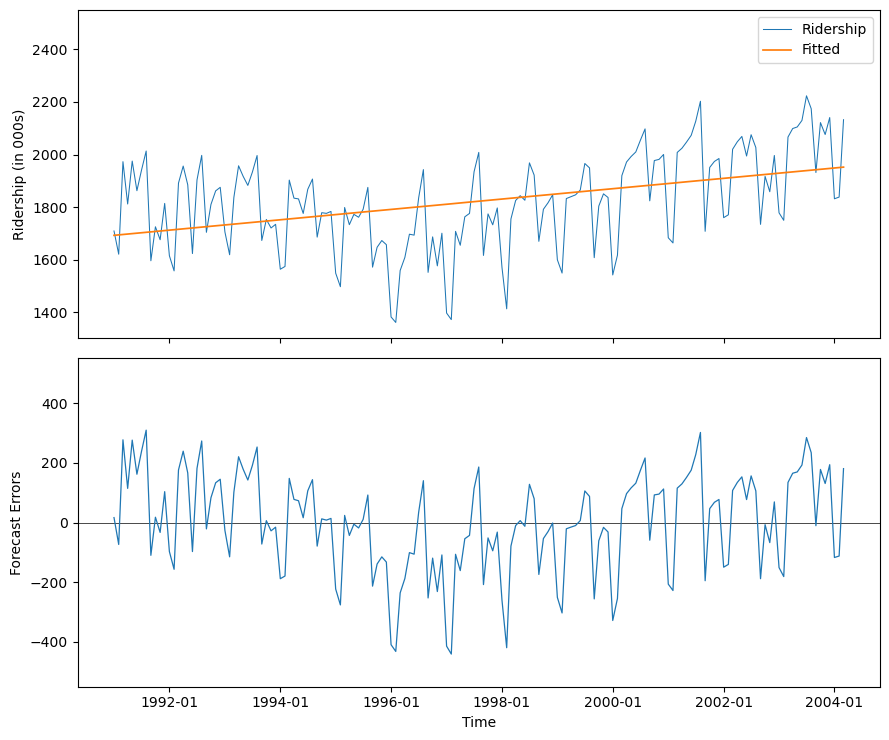

In [29]:
plt.close('all')    # per sicurezza, in caso di subplot rimastiu aperti da esecuzioni interrotte precedenti od errate

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5), sharex=True)

# 1) ridership + fit (linea continua)
axes[0].plot(df_full.index, df_full['Ridership'], linewidth=0.75, label='Ridership')
axes[0].plot(df_full.index, df_full['fitted'],   linewidth=1.25, label='Fitted')
axes[0].set_ylabel('Ridership (in 000s)')
axes[0].legend()

# 2) residui
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].plot(df_full.index, df_full['residual'], linewidth=0.9, label='Residuals')
axes[1].set_ylabel('Forecast Errors')
axes[1].set_xlabel('Time')

# limiti e formattazione dell'asse X (mesi)
axes[0].set_ylim(1300, 2550)
axes[1].set_ylim(-550, 550)
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

---

L'importante plot dei residui (*forecast errors*) ha una forma ad U, cioè i residui risentono del **lack of fit** (fit lineare su andamento quadratico di questa serie).

---

**Google AI Overview**:<br>
"Lack of fit" (LOF) è un termine statistico che indica quando un modello di regressione non descrive adeguatamente la relazione tra le variabili, rilevato tramite la presenza di residui anomali o attraverso un test statistico specifico. Il LOF suggerisce che potrebbero esserci importanti termini mancanti nel modello, come interazioni o termini quadratici, oppure che la relazione non è lineare come ipotizzato. Un test di mancanza di adattamento significativo indica che un modello differente potrebbe rappresentare meglio i dati.<br>

**Cosa significa "lack of fit"**<br>
- Modello inadeguato:<br>
Un modello di regressione ha una "lack of fit" (mancanza di adattamento) quando non riesce a catturare la vera relazione funzionale tra i fattori sperimentali e la variabile di risposta.<br>
- Residui:<br>
È possibile che il modello sia inadeguato se ci sono residui insolitamente grandi, che sono le differenze tra i valori osservati e i valori predetti dal modello.<br> 
- Termini mancanti:<br>
La mancanza di adattamento può verificarsi quando nel modello mancano termini importanti, come interazioni tra variabili o termini di ordine superiore (ad es. quadratici), che sono essenziali per descrivere i dati. <br>

**Come si rileva la "lack of fit"**<br>
- Test di lack-of-fit:
Si può eseguire un test statistico per verificare se la mancanza di adattamento è significativa. Questo test compara l'errore puro (dovuto alla variabilità intrinseca dei dati) con l'errore di "lack of fit" per determinare se c'è una deviazione sistematica dal modello. 
- Requisiti per il test:
Per eseguire un test di "lack of fit", è necessario avere osservazioni ripetute per almeno alcuni valori dei fattori indipendenti, al fine di stimare l'errore puro. 

**Cosa fare in caso di "lack of fit"**<br>
Se un test di "lack of fit" è significativo, significa che il modello non si adatta bene ai dati e può essere utile considerare: 
- Aggiungere termini di ordine superiore:<br>
Includere termini come interazioni o termini quadratici nel modello.
- Considerare trasformazioni:<br>
Applicare trasformazioni ai dati per cercare di ottenere una relazione più lineare.
- Verificare le condizioni di esecuzione:<br>
Controllare se ci sono stati problemi o particolarità nell'esecuzione dei dati sperimentali, specialmente se riguardano le repliche.
- Controllare i dati:<br>
Verificare la presenza di valori anomali (outliers) che potrebbero influenzare l'adattamento del modello.

# Fit quadratico

Ora costruiamo la matrice di disegno per il SECONDO modello, quello **quadratico**. Avevamo infatti visto nel *line chart* un andamento parabolico.<br>
Seguiamo lo stesso approccio usato per il fit lineare, e cioè:
- costruzione del dataframe completo (X+y) `df_full_quad`, con la colonna `t2` in più (rispetto al dataframe `df_full` del modello lineare)
- costruzione del modello `ridership_qm` tramite fit della formula `"Ridership ~ t + t2"` sul dataframe `df_full_quad` (con la funzione `smf.ols`)
- summary del modello `ridership_qm` e sua interpretazione
- eventuale estrazione di X e y dal modello `ridership_qm` con `model.model.exog` per X e `model.model.endog` per y (oppure con `dmatrices` di *patsy*)
- calcolo e plot dei valori fittati e dei residui

In [30]:
t = np.arange(len(ridership_ts))          # comodo

# costruzione della matrice (y+X)
df_full_quad = pd.DataFrame(
    {"Ridership": ridership_ts.values,
     "t": t,
     "t2": t**2
    },
    index=ridership_ts.index
)

display(df_full_quad)


,Ridership,t,t2
Date,,,
1991-01-01,1708.917,0,0
1991-02-01,1620.586,1,1
1991-03-01,1972.715,2,4
1991-04-01,1811.665,3,9
1991-05-01,1974.964,4,16
...,...,...,...
2003-11-01,2076.054,154,23716
2003-12-01,2140.677,155,24025
2004-01-01,1831.508,156,24336


Fittiamo ora il modello di regressione <u>quadratico</u> al dataframe, anche qui **senza stagionalità**.<br> 
Il modello polinomiale, ed in particolare quello quadratico, è un modello **facile da fittare** da un punto di vista matematico. Infatti, un modello di regressione è **'lineare' rispetto ai coefficienti $\beta_i$ , che sono le INCOGNITE della equazione, non rispetto alle variabili $t$ e $t^2$**, che sono NOTI. Possiamo dunque utilizzare ancora il metodo OLS e la funzione `smf.ols`

In [31]:
ridership_qm = smf.ols("Ridership ~ t + t2", data=df_full_quad).fit()

Il modello fittato è il seguente:
$$ \hat{Y} = \beta_0 + \beta_1t + \beta_2t^2$$

Il sommario del fit:

In [32]:
ridership_qm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ridership   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     38.48
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           2.61e-14
Time:                        16:15:14   Log-Likelihood:                -1020.4
No. Observations:                 159   AIC:                             2047.
Df Residuals:                     156   BIC:                             2056.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1849.8533     35.146     52.633      0.000    1780.429    1919.278
t             -4.3733      1.028     -4.255      0.000      -6.404      -2.343
t2             0.0381      0.006      6.047      0.000       0.026       0.051
==============================================================================
Omnibus:                        9.355   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.627
Skew:                          -0.505   Prob(JB):                       0.0134
Kurtosis:                       2.468   Cond. No.                     3.32e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interpretazione (NON AGGIORNATA) di chatGPT di questo secondo modello quadratico (confrontato con quello lineare):
![](output_sm_ols_2.png)

La valutazione del **condition number** della matrice di disegno:
![](cond_number.png)

L'eventuale estrazione di X e Y dal modello `ridership_qm` con `model.model.exog` per X e `model.model.endog` per y (oppure con `dmatrices` di *patsy*)

In [33]:
# Matrice X (predittori, inclusa la costante)
X = ridership_qm.model.exog             # X è una array numpy 2D
print("Matrice X:\n", X[:5], "\n")

# Vettore y (risposta)                  # X è un vettore array numpy 1D
y = ridership_qm.model.endog
print("Vettore y:\n", y[:5],"\n")

# Nomi delle colonne della design matrix
print("Nomi colonne X: \n", ridership_qm.model.exog_names)

Matrice X:
 [[ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]] 

Vettore y:
 [1708.917 1620.586 1972.715 1811.665 1974.964] 

Nomi colonne X: 
 ['Intercept', 't', 't2']


Vediamo ora i due **line plot dei valori fittati e dei residui** (*forecast errors*) <u>a confronto</u>:

In [34]:
# Aggiunta di due colonne al dataframe: previsioni e residui
df_full_quad["fitted"] = ridership_qm.predict(df_full_quad)
df_full_quad['residual'] = df_full_quad['Ridership'] - df_full_quad['fitted']
np.round(df_full_quad,2)

,Ridership,t,t2,fitted,residual
Date,,,,,
1991-01-01,1708.92,0,0,1849.85,-140.94
1991-02-01,1620.59,1,1,1845.52,-224.93
1991-03-01,1972.72,2,4,1841.26,131.46
1991-04-01,1811.66,3,9,1837.08,-25.41
1991-05-01,1974.96,4,16,1832.97,141.99
...,...,...,...,...,...
2003-11-01,2076.05,154,23716,2079.34,-3.29
2003-12-01,2140.68,155,24025,2086.73,53.94
2004-01-01,1831.51,156,24336,2094.20,-262.69


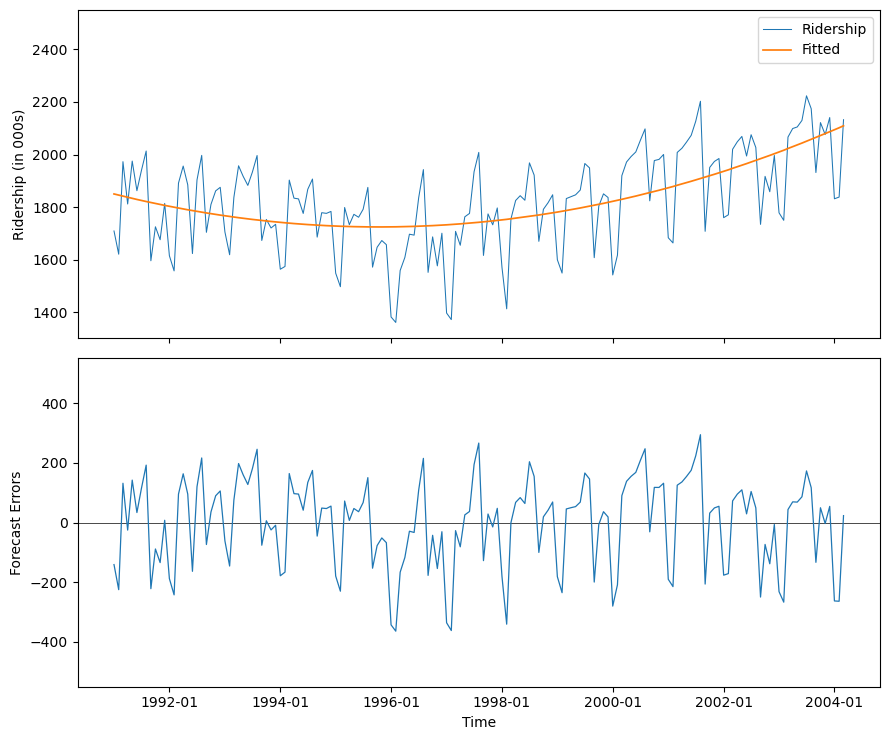

In [35]:
# costruzione del grafico unico con 2 subplot ed un unico asse X del tempo; no figure “spare” ---
plt.close('all')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5), sharex=True)

# 1) ridership + fit (linea continua)
axes[0].plot(df_full_quad.index, df_full_quad['Ridership'], linewidth=0.75, label='Ridership')
axes[0].plot(df_full_quad.index, df_full_quad['fitted'],   linewidth=1.25, label='Fitted')
axes[0].set_ylabel('Ridership (in 000s)')
axes[0].legend()

# 2) residui
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].plot(df_full_quad.index, df_full_quad['residual'], linewidth=0.9, label='Residuals')
axes[1].set_ylabel('Forecast Errors')
axes[1].set_xlabel('Time')

# limiti e formattazione dell'asse X (mesi)
axes[0].set_ylim(1300, 2550)
axes[1].set_ylim(-550, 550)
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

---

Da questi due plot vediamo che la forma quadratica **cattura bene il trend della serie**. In particolare, i residui (*forecast errors*) sono ora **privi di trend** ed esibiscono solo la stagionalità, che NON è stata modellata!

---

# Altre forme di trend?
In linea di principio <u>ogni forma di fit</u> che abbia una **rappresentazione matematica** può essere fittata alla serie: polinomiale di ordine > 2 (ad esempio cubica), esponenziale, power, ecc.<br>
Tuttavia l'assunzione sottostante al  modello è che quella forma sia **applicabile a tutto il periodo osservato ed anche al futuro**.<br>
Non si devono scegliere forme troppo complesse, che facilmente vanno in **overfitting**, rilevabile dall'andamento delle prestazioni del dataset di test (vedi più avanti).

# Fit con stagionalità
La stagionalità è catturata in un modello di regressione tramite una nuova variabile categorica, trasformata in variabili dummy che sono incluse nel modello come predittori.<br>
Usiamo qui la nuova variabile `Month`, esplosa poi nel modello in k-1 predittori dummy (12-1 = 11) per evitare problemi di multicollinearità tra le dummy e la costante $\beta_0$.<br>
In `statsmodels` è sufficiente usare una formula del tipo `Ridership` ~ `C(Month)`: le variabili dummy sono create automaticamente. Non includiamo il trend nel modello per vedere l'effetto della sola stagionalità.

Andiamo dunque a fittare un modello di questo tipo:

$$ \hat{Y} = \beta_0 + C(Month)$$

In [36]:
# DataFrame UNICO, omogeneo agli altri fit
df_full_season = pd.DataFrame(
    {"Ridership": ridership_ts.values,
    "Month": ridership_ts.index.month},
    index=ridership_ts.index)

display(df_full_season)

,Ridership,Month
Date,,
1991-01-01,1708.917,1
1991-02-01,1620.586,2
1991-03-01,1972.715,3
1991-04-01,1811.665,4
1991-05-01,1974.964,5
...,...,...
2003-11-01,2076.054,11
2003-12-01,2140.677,12
2004-01-01,1831.508,1


In [37]:
ridership_season = smf.ols("Ridership ~ C(Month)", data=df_full_season).fit()
ridership_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ridership   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     12.97
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           5.46e-17
Time:                        16:15:16   Log-Likelihood:                -998.29
No. Observations:                 159   AIC:                             2021.
Df Residuals:                     147   BIC:                             2057.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1620.2046     35.849     45.195      0.000    1549.358    1691.051
C(Month)[T.2]    -34.5223     50.699     -0.681      0.497    -134.714      65.670
C(Month)[T.3]    265.5785     50.699      5.238      0.000     165.386     365.771
C(Month)[T.4]    253.7747     51.664      4.912      0.000     151.674     355.875
C(Month)[T.5]    283.0744     51.664      5.479      0.000     180.974     385.175
C(Month)[T.6]    246.8086     51.664      4.777      0.000     144.708     348.909
C(Month)[T.7]    350.4347     51.664      6.783      0.000     248.334     452.535
C(Month)[T.8]    388.2474     51.664      7.515      0.000     286.147     490.348
C(Month)[T.9]     62.1486     51.664      1.203      0.231     -39.952     164.249
C(Month)[T.10]   205.5458     51.664      3.978      0.000     103.445     307.647
C(Month)[T.11]   192.9714     51.664      3.735      0.000      90.871     295.072
C(Month)[T.12]   238.6901     51.664      4.620      0.000     136.589     340.791
==============================================================================
Omnibus:                        2.295   Durbin-Watson:                   0.211
Prob(Omnibus):                  0.317   Jarque-Bera (JB):                1.969
Skew:                           0.153   Prob(JB):                        0.374
Kurtosis:                       2.549   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

La baseline è il mese 1, non incluso nei predittori del modello.

Vediamo ora i due **line plot dei valori fittati e dei residui** (*forecast errors*) <u>a confronto</u>:

In [38]:
# Aggiunta di due colonne al dataframe: previsioni e residui
df_full_season["fitted"]   = ridership_season.predict(df_full_season)
df_full_season["residual"] = df_full_season["Ridership"] - df_full_season["fitted"]
np.round(df_full_season,2)

,Ridership,Month,fitted,residual
Date,,,,
1991-01-01,1708.92,1,1620.20,88.71
1991-02-01,1620.59,2,1585.68,34.90
1991-03-01,1972.72,3,1885.78,86.93
1991-04-01,1811.66,4,1873.98,-62.31
1991-05-01,1974.96,5,1903.28,71.69
...,...,...,...,...
2003-11-01,2076.05,11,1813.18,262.88
2003-12-01,2140.68,12,1858.89,281.78
2004-01-01,1831.51,1,1620.20,211.30


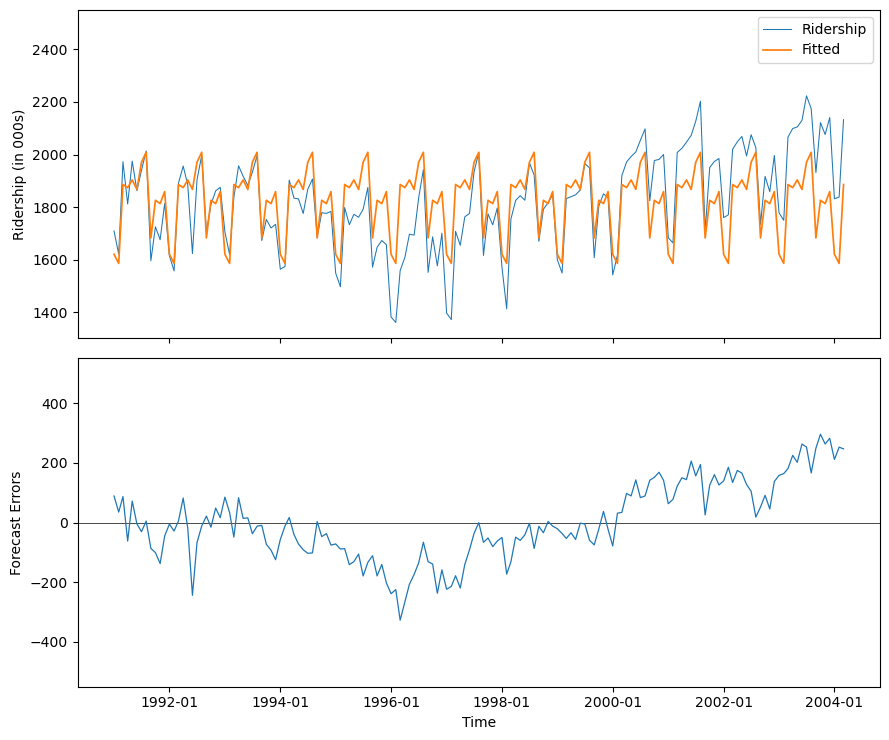

In [39]:
# costruzione del grafico unico con 2 subplot ed un unico asse X del tempo; no figure “spare” ---

plt.close('all')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5), sharex=True)

# 1) ridership + fit (linea continua)
axes[0].plot(df_full_season.index, df_full_season['Ridership'], linewidth=0.75, label='Ridership')
axes[0].plot(df_full_season.index, df_full_season['fitted'],   linewidth=1.25, label='Fitted')
axes[0].set_ylabel('Ridership (in 000s)')
axes[0].legend()

# 2) residui
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].plot(df_full_season.index, df_full_season['residual'], linewidth=0.9, label='Residuals')
axes[1].set_ylabel('Forecast Errors')
axes[1].set_xlabel('Time')

# limiti e formattazione dell'asse X (mesi)
axes[0].set_ylim(1300, 2550)
axes[1].set_ylim(-550, 550)
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

Il primo plot evidenzia come il modello cattura bene la stagionalità della serie, e non il trend (non avendolo modellato!).<br>
Il secondo plot (dei residui), cioè delle differenze tra valori effettivi e fittati, mostra chiaramente la forma ad U del trend.<br>
Il modello cattura la **stagionalità additiva**: cioè il  valore medio di Y (*Ridership*) in un dato mese è una determinata quantità più o meno di quella del mese baseline (January).<br>
Per modellare una stagionalità **moltiplicativa**, nella quale cioè il  valore medio di Y (*Ridership*) in un dato mese è una determinata quantità moltiplicata quella del mese baseline (January), si fitta un modello analogo con risposta $log(Y)$.
 

# Fit con trend e stagionalità

Come ultimo passo, fittiamo un modello con trend quadratico e stagionalità tramite i predittori di entrambi i tipi visti prima.<br>
Il modello fittato ha dunque la seguente forma:
$$ \hat{Y} = \beta_0 + \beta_1t + \beta_2t^2 + C(Month)$$

I predittori sono ora 13: 11 dummy mensili, $t$ e $t^2$.

In [39]:
t = np.arange(len(ridership_ts))

df_full_quad_seas = pd.DataFrame(
    {"Ridership": ridership_ts.values,
     "t": t,
     "t2": t**2,
     "Month": ridership_ts.index.month},
    index=ridership_ts.index
)

display(df_full_quad_seas)

,Ridership,t,t2,Month
Date,,,,
1991-01-01,1708.917,0,0,1
1991-02-01,1620.586,1,1,2
1991-03-01,1972.715,2,4,3
1991-04-01,1811.665,3,9,4
1991-05-01,1974.964,4,16,5
...,...,...,...,...
2003-11-01,2076.054,154,23716,11
2003-12-01,2140.677,155,24025,12
2004-01-01,1831.508,156,24336,1


In [40]:
ridership_qm_seas = smf.ols("Ridership ~ t + t2 + C(Month)", data=df_full_quad_seas).fit()
ridership_qm_seas.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ridership   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     64.82
Date:                Sun, 14 Sep 2025   Prob (F-statistic):           1.24e-53
Time:                        00:20:40   Log-Likelihood:                -899.70
No. Observations:                 159   AIC:                             1827.
Df Residuals:                     145   BIC:                             1870.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1651.4630     24.821     66.536      0.000    1602.406    1700.520
C(Month)[T.2]    -36.1436     27.458     -1.316      0.190     -90.414      18.127
C(Month)[T.3]    262.2533     27.459      9.551      0.000     207.981     316.525
C(Month)[T.4]    271.5141     28.000      9.697      0.000     216.174     326.854
C(Month)[T.5]    299.4401     27.999     10.695      0.000     244.101     354.779
C(Month)[T.6]    261.7180     27.999      9.348      0.000     206.380     317.056
C(Month)[T.7]    363.8054     27.999     12.994      0.000     308.467     419.144
C(Month)[T.8]    399.9966     27.999     14.286      0.000     344.658     455.336
C(Month)[T.9]     72.1940     28.000      2.578      0.011      16.853     127.534
C(Month)[T.10]   213.8048     28.001      7.636      0.000     158.462     269.147
C(Month)[T.11]   199.3614     28.002      7.119      0.000     144.016     254.707
C(Month)[T.12]   243.1286     28.004      8.682      0.000     187.780     298.478
t                 -4.8576      0.501     -9.705      0.000      -5.847      -3.868
t2                 0.0413      0.003     13.458      0.000       0.035       0.047
==============================================================================
Omnibus:                        8.117   Durbin-Watson:                   0.719
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                7.942
Skew:                          -0.531   Prob(JB):                       0.0189
Kurtosis:                       3.266   Cond. No.                     1.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$R^2$ alto!

Per finire i soliti due plot:

In [41]:
# Aggiunta di due colonne al dataframe: previsioni e residui
df_full_quad_seas["fitted"] = ridership_qm_seas.predict(df_full_quad_seas)
df_full_quad_seas['residual'] = df_full_quad_seas['Ridership'] - df_full_quad_seas['fitted']
np.round(df_full_quad_seas,2)

,Ridership,t,t2,Month,fitted,residual
Date,,,,,,
1991-01-01,1708.92,0,0,1,1651.46,57.45
1991-02-01,1620.59,1,1,2,1610.50,10.08
1991-03-01,1972.72,2,4,3,1904.17,68.55
1991-04-01,1811.66,3,9,4,1908.78,-97.11
1991-05-01,1974.96,4,16,5,1932.13,42.83
...,...,...,...,...,...,...
2003-11-01,2076.05,154,23716,11,2081.45,-5.39
2003-12-01,2140.68,155,24025,12,2133.11,7.57
2004-01-01,1831.51,156,24336,1,1897.96,-66.45


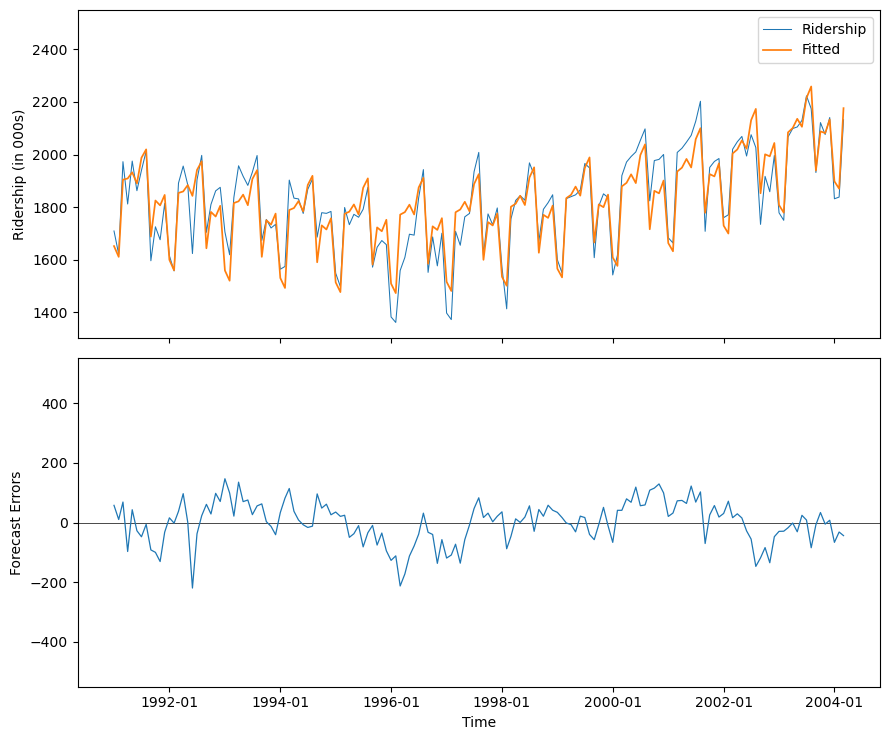

In [42]:
# costruzione del grafico unico con 2 subplot ed un unico asse X del tempo; no figure “spare” ---

plt.close('all')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5), sharex=True)

# 1) ridership + fit (linea continua)
axes[0].plot(df_full_quad_seas.index, df_full_quad_seas['Ridership'], linewidth=0.75, label='Ridership')
axes[0].plot(df_full_quad_seas.index, df_full_quad_seas['fitted'],   linewidth=1.25, label='Fitted')
axes[0].set_ylabel('Ridership (in 000s)')
axes[0].legend()

# 2) residui
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].plot(df_full_quad_seas.index, df_full_quad_seas['residual'], linewidth=0.9, label='Residuals')
axes[1].set_ylabel('Forecast Errors')
axes[1].set_xlabel('Time')

# limiti e formattazione dell'asse X (mesi)
axes[0].set_ylim(1300, 2550)
axes[1].set_ylim(-550, 550)
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

I residui ora esprimono solo la **casualità**.

# L'auto-correlazione

L'ultima componente da esaminare è **l'[auto-correlazione](Autocorrelation.png)**, che riprenderemo meglio nel notebook *C. Forecasting delle TS con la Regressione.ipynb*.<br>
Da notare, comunque, che questa auto-correlazione, come si vede bene nel grafico prima linkato, non è una stagionalità perchè:
* il t0 di inizio del ciclo (di decadimento) è irregolare (non prevedibile);
* il pattern ciclico (il decadimento) ha forme differenti tra loro.

# Riassunto sulle componenti
Con l'auto-correlazione abbiamo menzionato tutte le componenti di una serie temporale.<br>
E' davvero importante imparare a riconoscere i **pattern di time-series** più diffusi, perchè i metodi di Machine Learning che si applicano sono differenti.<br>
Attenzione: si tratta comunque sempre di valutazioni in parte **soggettive**.<br>

[I trend e le stagionalità GLOBALI più comuni (Galit Shmueli - Axelrod Schnall Publishers - 2016)](Common_patterns_shmueli.png)<br>

[Video riassuntivo sui pattern (da *coursera*)](https://www.youtube.com/watch?v=_z-a6WoNC2s&t=131s)<br>

[Le slide del video precedente - parte 1](Common_patterns_in_TS.png)<br>
[Le slide del video precedente - parte 2](Common_patterns_in_TS_2.png)<br>
[Le slide del video precedente - parte 3](Common_patterns_in_TS_3.png)<br>
[Le slide del video precedente - parte 4](Common_patterns_in_TS_4.png)<br>

**I plot visti sopra servono non solo ad identificare meglio le 6 componenti, ma anche a decidere se la natura di trend/pattern/stagionalità è <u>locale o globale</u>**.

# Metodi (cioè algoritmi) di forecasting (*ML predittivo*)

Ora vogliamo fare **PREVISIONE** sul futuro (forecasting). Potremmo usare il modello di regressione quadratica con stagionalità prima fittato. [In proposito vedi il notebook *C. Forecasting delle TS con la Regressione.ipynb* per la previsione con la regressione]. Vogliamo qui, per il momento, usare due algoritmi più semplici (non parametrici): **naive forecast** e il **seasonal naive forecast**.

# Partizionamento dei dati e previsione (*forecast*)
Come per tutti i metodi di ML *predittivo*, occorre per prima cosa suddividere il dataset in **training** set, sul quale si allena il modello, e **test set (o validation set**), sul quale lo si valuta. Le previsioni saranno poi fatte per i **valori futuri**. Cioè il passato serve a prevedere il futuro ed è diviso in training e test.<br>

Lavoriamo sulla serie dati completa (159 mesi).

[In questa voce di Wikipedia](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets) è trattato il tema in generale; ci sono delle peculiarità del partizionamento dati per le serie temporali che vedremo più avanti (in particolare: la successione cronologica dei dataset e non l'estrazione casuale).<br>

Ecco la [regola del pollice di Hastie & Tibshirani](Percentuali_partizionamento.png) per la suddivisione dei dati (in 3 dataset, se la serie storica ed i dati in generale sono numerosi - ***data richness***).

In [43]:
# split dati in periodo di training e periodo di validazione (=test!) del modello (SUCCESSIVI per le serie temporali):

nValid = 36                           # periodo di validazione (test): gli ultimi 36 mesi della serie (22%) 
                                      # (da Aprile 2001 a Marzo 2004); 
                                      # non c'è casualità (e quindi non serve un seme).

nTrain = len(ridership_ts) - nValid   # periodo di training: i 123 mesi precedenti (da Gennaio 1991 a marzo 2001).
                                      # [la serie totale è di 159 mesi --> 159-36 = 123.]
    
# partizionamento dei dati [vedi tecniche di subsetting di python e pandas]:
train_ts = ridership_ts[:nTrain]    # subsetting: tutti gli elementi della serie sino a 'nTrain'-1; 
valid_ts = ridership_ts[nTrain:]    #    "          "                            da 'nTrain' in poi;
                                    # --> regole di subsetting delle 'Series' coerenti con quelle dei 'dataframe'.
print(train_ts.shape)
print(valid_ts.shape)

# --> ESAME variabili (nome, tipo, shape, valore, ecc) con il Variable Inspector

(123,)
(36,)


In [44]:
print(valid_ts)

Date
2001-04-01    2023.792
2001-05-01    2047.008
2001-06-01    2072.913
2001-07-01    2126.717
2001-08-01    2202.638
2001-09-01    1707.693
2001-10-01    1950.716
2001-11-01    1973.614
2001-12-01    1984.729
2002-01-01    1759.629
2002-02-01    1770.595
2002-03-01    2019.912
2002-04-01    2048.398
2002-05-01    2068.763
2002-06-01    1994.267
2002-07-01    2075.258
2002-08-01    2026.560
2002-09-01    1734.155
2002-10-01    1916.771
2002-11-01    1858.345
2002-12-01    1996.352
2003-01-01    1778.033
2003-02-01    1749.489
2003-03-01    2066.466
2003-04-01    2098.899
2003-05-01    2104.911
2003-06-01    2129.671
2003-07-01    2223.349
2003-08-01    2174.360
2003-09-01    1931.406
2003-10-01    2121.470
2003-11-01    2076.054
2003-12-01    2140.677
2004-01-01    1831.508
2004-02-01    1838.006
2004-03-01    2132.446
Freq: MS, Name: Ridership, dtype: float64


In [45]:
# PROVE di subsetting di 'train_ts' (utili per dopo):
print(train_ts,'\n')            # tutta la serie
print(train_ts.iloc[0])         # il primo elemento
print(train_ts.iloc[-1])        # l'ultimo elemento
print(train_ts.iloc[-2:])       # gli ultimi due elementi

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
                ...   
2000-11-01    1981.408
2000-12-01    2000.153
2001-01-01    1683.148
2001-02-01    1663.404
2001-03-01    2007.928
Freq: MS, Name: Ridership, Length: 123, dtype: float64 

1708.917
2007.928
Date
2001-02-01    1663.404
2001-03-01    2007.928
Freq: MS, Name: Ridership, dtype: float64


Utilizziamo ora **due metodi di forecasting** (del prossimo valore futuro) **semplici (per imparare) ma spesso efficaci** (tant'è che costituiscono un "benchmark" di riferimento non facile da battere):
* **naive forecast**: l'ultimo valore, cioè il valore dell'elemento k+1 della serie (*forecasted*) è semplicemente il valore dell'ultimo elemento k (*actual*);
* **seasonal naive forecast** (stagionale): utile quando la serie presenta delle <u>stagionalità</u>; è l'ultimo valore *simile* nella stagione. Ad esempio: per il forecast di Aprile 2001, *seasonal naive forecast* usa il numero viaggiatori dell'ultimo aprile del set di training (nel 2000). Lo stesso per il forecast di aprile 2002 (il valore di aprile 2000, nuovamente, perchè DENTRO il dataset di training)


In [46]:
# Previsioni con i due metodi:

naive_pred = pd.Series(train_ts.iloc[-1], index=valid_ts.index) # --> con 'naive forecast' la previsione è 
                                                                #     semplicemente l'ultimo valore

last_season = train_ts.iloc[-12:]                               # gli ultimi 12 valori (la stagionalità da considerare)
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values, index=valid_ts.index)

Cosa fa questa istruzione?
```python
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values, index=valid_ts.index)
```

Estrae gli ultimi 12 valori da `train_ts`, che rappresentano l’ultima stagione completa (la stagionalità è mensile).<br>
Ripete quei 12 valori per 5 volte (ottenendo una serie di 60 valori).<br>
Prende solo i primi `len(valid_ts)` valori da quella serie (es. i primi 36, se la validazione è su 3 anni).<br>
Crea la serie di previsione con questi valori, mantenendo le stesse date di `valid_ts`.<br>

Esempio concreto: se `train_ts` finisce a dicembre e contiene dati mensili, `last_season` sarà da gennaio a dicembre. La previsione sarà:<br>
Gennaio → uguale a gennaio scorso<br>
Febbraio → uguale a febbraio scorso<br>
… e così via per 3 anni (36 mesi)


In [47]:
print(naive_pred)              # --> 36 valori tutti uguali
print('\n',seasonal_pred)      # --> 36 valori uguali a quello del rispettivo mese dell'ultimo anno ('last_season')

Date
2001-04-01    2007.928
2001-05-01    2007.928
2001-06-01    2007.928
2001-07-01    2007.928
2001-08-01    2007.928
2001-09-01    2007.928
2001-10-01    2007.928
2001-11-01    2007.928
2001-12-01    2007.928
2002-01-01    2007.928
2002-02-01    2007.928
2002-03-01    2007.928
2002-04-01    2007.928
2002-05-01    2007.928
2002-06-01    2007.928
2002-07-01    2007.928
2002-08-01    2007.928
2002-09-01    2007.928
2002-10-01    2007.928
2002-11-01    2007.928
2002-12-01    2007.928
2003-01-01    2007.928
2003-02-01    2007.928
2003-03-01    2007.928
2003-04-01    2007.928
2003-05-01    2007.928
2003-06-01    2007.928
2003-07-01    2007.928
2003-08-01    2007.928
2003-09-01    2007.928
2003-10-01    2007.928
2003-11-01    2007.928
2003-12-01    2007.928
2004-01-01    2007.928
2004-02-01    2007.928
2004-03-01    2007.928
Freq: MS, dtype: float64

 Date
2001-04-01    1971.493
2001-05-01    1992.301
2001-06-01    2009.763
2001-07-01    2053.996
2001-08-01    2097.471
2001-09-01    1823.7

In [48]:
ridership_ts['2000':'2004'] # i valori effettivi (per confronto)

Date
2000-01-01    1541.660
2000-02-01    1616.928
2000-03-01    1919.538
2000-04-01    1971.493
2000-05-01    1992.301
2000-06-01    2009.763
2000-07-01    2053.996
2000-08-01    2097.471
2000-09-01    1823.706
2000-10-01    1976.997
2000-11-01    1981.408
2000-12-01    2000.153
2001-01-01    1683.148
2001-02-01    1663.404
2001-03-01    2007.928
2001-04-01    2023.792
2001-05-01    2047.008
2001-06-01    2072.913
2001-07-01    2126.717
2001-08-01    2202.638
2001-09-01    1707.693
2001-10-01    1950.716
2001-11-01    1973.614
2001-12-01    1984.729
2002-01-01    1759.629
2002-02-01    1770.595
2002-03-01    2019.912
2002-04-01    2048.398
2002-05-01    2068.763
2002-06-01    1994.267
2002-07-01    2075.258
2002-08-01    2026.560
2002-09-01    1734.155
2002-10-01    1916.771
2002-11-01    1858.345
2002-12-01    1996.352
2003-01-01    1778.033
2003-02-01    1749.489
2003-03-01    2066.466
2003-04-01    2098.899
2003-05-01    2104.911
2003-06-01    2129.671
2003-07-01    2223.349
2003-0

[Il funzionamento del Seasonal Naive Forecast su questi dataset](SNF_esempio.png).<br>

Nel Machine Learning, e quindi anche nelle serie temporali, c'è in genere un **benchmark base, anche detto di riferimento**, che sono i risultati forniti dall'algoritmo più semplice. Il benchmark base è quello "da battere".<br><br>
Il **benchmark base** nel TSF è, come spesso nel ML, <u>la mera MEDIA di tutti i valori della serie</u>.<br><br>
NF e SNF battono in genere il benchmark base, cioè forniscono previsioni migliori perchè considerano solo il <u>passato recente</u> (anche se solo quello ultimissimo), e costituiscono quindi, di fatto, il **vero benchmark di riferimento** che gli altri metodi di TSF devono cercare di battere (previsioni ancora migliori).<br><br>
**Previsione buona/ottima**: il <u>residuo</u>, cioè la differenza tra il valore t+k della serie <u>previsto e quello effettivo</u>, è piccolo. Il residuo è anche detto: *errore di forecast*.<br>
Storicamente, il termine *residuo* è nato per indicare ciò che RESTA dopo l'applicazione (il fit) del modello alla serie, cioè ciò che NON è modellato dal modello stesso, cioò che non è **SPIEGATO** da esso.<br>
Il residuo è riferito alla SINGOLA previsione; i vari residui possono poi essere aggregati in una metrica di valutazione complessiva della bontà predittiva del modello su TUTTA la serie, o comunque su tutto l'intervallo di osservazione scelto (ad esempio di test).

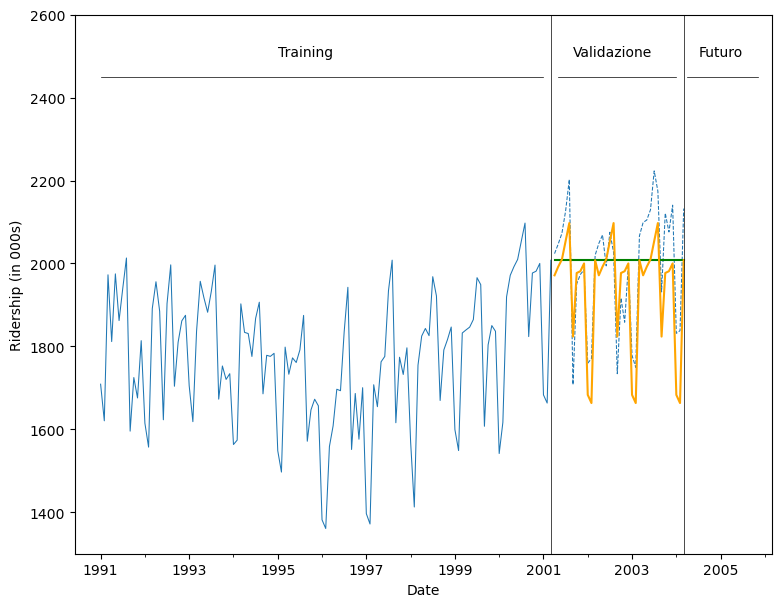

In [49]:
# plot dei forecast e degli actual nel dataset di training ed in quello di validazione:

ax = train_ts.plot(color='C0', linewidth=0.75, figsize=(9,7))
valid_ts.plot(ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
# ax.set_xlim('1990', '2006-06-01')
ax.set_ylim(1300, 2600)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')

naive_pred.plot(ax=ax, color='green')
seasonal_pred.plot(ax=ax, color='orange')


# Determinare le coordinate per disegnare frecce e linee:
one_month = pd.Timedelta('31 days')
xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
xfuture = (max(valid_ts.index) + one_month, max(valid_ts.index) + 20 * one_month)
xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
xvf = xvalid[1] + 0.5 * (xfuture[0] - xvalid[1])
ax.set_xlim(min(train_ts.index) - 6 * one_month, max(valid_ts.index) + 24 * one_month)

ax.add_line(plt.Line2D(xtrain, (2450, 2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xvalid, (2450, 2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xfuture, (2450, 2450), color='black', linewidth=0.5))
ax.text('1995', 2500, 'Training')
ax.text('2001-9', 2500, 'Validazione')
ax.text('2004-7', 2500, 'Futuro')
ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)
plt.show()

                             # --> per il dataset di validazione il grafico mostra:
                             #     * forecast naive, UGUALE per tutti i mesi: la linea verde orizzontale;
                             #     * forecast naive stagionale, VARIABILE: la curva arancione (si noti la ciclicità 
                             #       triennale);
                             #     * i valori effettivi (actual): la curva punteggiata.

# Valutazione della capacità predittiva
Infine, come in tutte le tecniche di ML previsionali (supervisionate), misuriamo in modo oggettivo **l'accuratezza** dei due metodi naive ora visti, con le metriche delle previsioni numeriche: ME, [Rooted MSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation), MAE, ecc. NB. [questa](RMSE_TS.png) è la formula dell'RMSE della pagina Wikipedia da usare per le serie temporali]<br>
L'accuratezza si misura sempre e solo sul dataset di validazione/test, perchè quello di training è già stato usato per allenare il modello (*il fitting*). L'accuratezza del futuro non è misurabile perchè NON conosciamo i valori effettivi (futuri); invece, li conosciamo per il dataset di validazione.

Per una definizione in Python delle suddette metriche (anche dette *loss function*) vedi il codice dell'utility *regressionSummary* a questo [indirizzo github](https://github.com/gedeck/dmba) [e poi --> src --> dmba --> metric.py].

In [50]:
regressionSummary(valid_ts, naive_pred)              # il primo argomento è la serie effettiva, il secondo è quella 
                                                     # prevista con forecast naive.


Regression statistics

                      Mean Error (ME) : -14.7177
       Root Mean Squared Error (RMSE) : 142.7551
            Mean Absolute Error (MAE) : 115.9234
          Mean Percentage Error (MPE) : -1.2750
Mean Absolute Percentage Error (MAPE) : 6.0214


La metrica di errore aggregato più affidabile è RMSE.<br>
RMSE = 142.75 vuol dire che, in media, l'errore di previsione del metodo naive forecast è di +/- 142.75.

In [51]:
np.power(142.7551,2) # --> MSE (senza radice quadrata): non è nella scala della risposta (ridership)
                     #     20379 migliaia significa 20 milioni e rotti 

np.float64(20379.01857601)

Ecco la formula matematica (presa da Wikipedia) dell'RMSD (sinonimo di RMSE):<br>
![](RMSE_TS.png)

In [52]:
regressionSummary(valid_ts, seasonal_pred)           # il primo argomento è la serie effettiva, il secondo è quella 
                                                     # prevista con seasonal forecast naive.


Regression statistics

                      Mean Error (ME) : 54.7296
       Root Mean Squared Error (RMSE) : 95.6243
            Mean Absolute Error (MAE) : 84.0941
          Mean Percentage Error (MPE) : 2.6528
Mean Absolute Percentage Error (MAPE) : 4.2477


**NOTE** sulle metriche di errore:
* poichè il dataset 'Amtrak' ha delle stagionalità mensili, il metodo stagionale (Seasonal Naive Forecast) vince nettamente (sul Naive Forecast) con tutte le metriche; 
* le metriche di "norma-0" possono fornire valori negativi;
* in generale, le metriche di errore di norma-2 (L2 norm, es MSE oppure RMSE), cioè con i quadrati, sono preferibili alle norme-1 (L1-norm, es MAE), cioè i valori assoluti, perchè sempre differenziabili (su tutto il dominio della variabile indipendente).
                            


Ancorchè in questa serie temporale Amtrak (e con questi subset di training e di validazione: 123 e 36 mesi) l'errore di training sia maggiore di quello di test/validazione (cosa poco usuale, peraltro), **si deve comunque usare sempre e solo  l'errore sul validation test perchè è più significativo**.

In [53]:
# Ecco come si calcola l'errore di training:

print('\n','naive model in training set')
regressionSummary(train_ts[1:], train_ts[:-1]) # 

print('\n','seasonal model in training set')
regressionSummary(train_ts[12:], train_ts[:-12])                            


 naive model in training set

Regression statistics

                      Mean Error (ME) : 2.4509
       Root Mean Squared Error (RMSE) : 168.1470
            Mean Absolute Error (MAE) : 125.2975
          Mean Percentage Error (MPE) : -0.3460
Mean Absolute Percentage Error (MAPE) : 7.2714

 seasonal model in training set

Regression statistics

                      Mean Error (ME) : 13.9399
       Root Mean Squared Error (RMSE) : 99.2656
            Mean Absolute Error (MAE) : 82.4920
          Mean Percentage Error (MPE) : 0.5851
Mean Absolute Percentage Error (MAPE) : 4.7153


La funzione `regressionSummary` prima utilizzata non riporta la metrica MSE, che alcuni preferiscono utilizzare. Vediamo allora come calcolare MSE in python (per il caso Amtrak) del metodo **SNF**:

In [54]:
# MSE per il SNF (calcolato con scikit-learn)
from sklearn.metrics import mean_squared_error   # RMSE non è direttamente disponibile
MSE = mean_squared_error(y_true=valid_ts,y_pred=seasonal_pred)  
print("Mean Square Error sk-learn: ",round(MSE,2))

# MSE sempre per il SNF (calcolato con 'numpy'):
MSE_2 = np.square(np.subtract(valid_ts,seasonal_pred)).mean()   # MSE calcolato con 'numpy'
print("Mean Square Error numpy: ",round(MSE_2,2))

# i due RMSE:
RMSE = math.sqrt(MSE)
RMSE_2 = math.sqrt(MSE_2)
print("Root Mean Square Error (scikit-learn): ",round(RMSE,2))
print("Root Mean Square Error (numpy): ",round(RMSE_2,2))

Mean Square Error sk-learn:  9144.01
Mean Square Error numpy:  9144.01
Root Mean Square Error (scikit-learn):  95.62
Root Mean Square Error (numpy):  95.62


---

> **Bottom-line**: il benchmark di riferimento per la serie Amtrak (sul dataset di validazione) è quindi **95.62** (del Seasonal NF), che rappresenta il valore da battere per altri eventuali algoritmi (vedi il notebook *C. Forecasting delle TS con la Regressione*).
>

---

**Come utilizzare questi numeri**? Per due scopi:
- **confrontare metodi TSF differenti** e valutarli comparativamente sul validation set --> il metodo con metrica di errore (ad es. RMSE) più bassa sarà quello che utilizziamo per le VERE previsioni (valori FUTURI della serie non ancora noti);
- **interpretare** i risultati (le previsioni)

In [55]:
seasonal_pred 

Date
2001-04-01    1971.493
2001-05-01    1992.301
2001-06-01    2009.763
2001-07-01    2053.996
2001-08-01    2097.471
2001-09-01    1823.706
2001-10-01    1976.997
2001-11-01    1981.408
2001-12-01    2000.153
2002-01-01    1683.148
2002-02-01    1663.404
2002-03-01    2007.928
2002-04-01    1971.493
2002-05-01    1992.301
2002-06-01    2009.763
2002-07-01    2053.996
2002-08-01    2097.471
2002-09-01    1823.706
2002-10-01    1976.997
2002-11-01    1981.408
2002-12-01    2000.153
2003-01-01    1683.148
2003-02-01    1663.404
2003-03-01    2007.928
2003-04-01    1971.493
2003-05-01    1992.301
2003-06-01    2009.763
2003-07-01    2053.996
2003-08-01    2097.471
2003-09-01    1823.706
2003-10-01    1976.997
2003-11-01    1981.408
2003-12-01    2000.153
2004-01-01    1683.148
2004-02-01    1663.404
2004-03-01    2007.928
Freq: MS, dtype: float64

Alla luce del RMSE (= 95.62) le previsioni fornite dal metodo TSF (qui SNF), elencate per comodità sopra, sono da **intendersi MEDIAMENTE errate per +/- 95.62**, cioè, in altre parole, 1971.493 è la **previsione PUNTUALE** per APR-04.<br>
La **previsione INTERVALLARE** di APR-04, utile per fornire l'incertezza, è così calcolata:
- [(1971.493 - 1.96x95.62),(1971.43 + 1.96x95.62)] è la previsione INTERVALLARE al livello di confidenza del 95%
Facciamo il calcolo in  Python:

In [56]:
print([(1971.493 - 1.96*95.62),(1971.43 + 1.96*95.62)])

[1784.0778, 2158.8452]


Uno dei vantaggi di RMSE, a differenza dell'MSE, è proprio che, essendo definito nella **stessa scala originaria** (qui  le migliaia di passeggeri mensili), può essere utilizzato per costruire gli INTERVALLI di CONFIDENZA.  

Le previsioni ora viste, come detto, sono **puntuali**. In realtà, come detto, gli algoritmi di ML predittivo forniscono previsioni **intervallari**: la stima puntuale è semplicemente il centro dell'intervallo, il cosiddetto *punto di ancoraggio*. Le previsioni intervallari hanno **un livello di confidenza**, che in genere è 90%, 95%, 99%. La scelta del livello di confidenza dipende dal grado di rischio che tolleriamo. E' una decisione del business, non tecnica o matematica. Ad esempio, un livello del 95% significa che **accettiamo il 5% di errore**, cioè -in concreto - che in un caso su 20 il valore effettivo di Y (che conosceremo solo nel futuro) sarà fuori dalla stima intervallare.

---

**Bottom-line**: la previsione puntuale è più PRECISA, la previsione intervallare è più ACCURATA. Purtroppo, gli utenti ed i clienti preferiscono la stima puntuale perchè è più "rassicurante" e perchè non cultura statistica. In realtà, la stima intervallare è molto più informativa perchè ci dà contezza della incertezza, ineliminabile nelle previsioni.

---

Forecaster delle serie temporali in genere migliori del naive e seasonal naive sono (ad esempio):
* regressione
* smoothing
* exponential smoothing
* ecc

Nei prossimi notebook (in particolare in *C. Forecasting delle TS con la Regressione*) vedremo se questi metodi (più sofisticati) riescono a battere il benchmark 95.62 del SNF.

**[NOTA matematica sulle *loss function* - facoltativo]**<br>
[Slide 1](Slide_loss_function_1.png)<br>
[Slide 2](Slide_loss_function_2.png)<br>
[Slide 3](Slide_loss_function_3.png)

# Forecast sul futuro
Per fare FORECAST del FUTURO (quello che ci interessa), occorre RICOMBINARE i due dataset (cioè considerare nuovamente **l'intero** dataset originale) e riadattare (*ri-fittare*) il metodo **scelto** (qui il naive stagionale) sulla serie completa.<br>
Ancorchè ciò sia comune anche con i dati *cross-sectional*, con le *time series* ciò è **indispensabile**. I motivi sono tre:
- il dataset di test/validazione è il più recente e perciò quello che contiene **le informazioni di maggior valore ed attualità**;
- con più dati alcuni metodi **prevedono meglio** (cioè laloro accuratezza è maggiore);
- se le previsioni si basano solo sul training data, esse sono **parecchio (troppo?) avanti nel tempo**

Possiamo ricombinare il dataset intero perchè le metriche di fitting - utili per scegliere il modello migliore - le abbiamo ottenute dal dataset di training e l'RMSE (o simili) - utile per altri versi - l'abbiamo ottenuto dal dataset di validazione. 

## CV con le TS? 
Le serie temporali (o altri dati intrinsecamente ordinati) possono essere problematici per la convalida incrociata (CV).
Un approccio tipico (ma **errato** per le TS) con la CV per TS, qui k=6 (numero-iterazioni) --> 6 fold, è il seguente:
* iter 1: training [1 2 3 4 5], test [6]
* iter 2: training [1 2 3 4 6], test [5]
* iter 3: training [1 2 3 5 6], test [4]
* iter 4: training [1 2 4 5 6], test [3]
* iter 5: training [1 3 4 5 6], test [2]
* iter 6: training [2 3 4 5 6], test [1]
dove il training set è ordinato temporalmente, ma non il test set rispetto al training set.

Se qualche prodotto emerge nell'anno 3 e rimane per 4-6 anni, i dataset NON sono più indipendenti.

Un approccio più frequente (per la CV nelle TS) è il **concatenamento diretto**, in cui la procedura è simile a questa:
* iter 1: training [1],         test [2]
* iter 2: training [1 2],       test [3]
* iter 3: training [1 2 3],     test [4]
* iter 4: training [1 2 3 4],   test [5]
* iter 5: training [1 2 3 4 5], test [6]<br>
In questo caso il numero-iter = numero-fold -1

I dati di training sono sempre **consecutivi (senza buchi)**, i dati di test sempre successivi a quelli di training.
E’ una suddivisione più corretta, anche perché prevede sempre dati futuri in base a dati passati.<br>
Per eventualmente ovviare alla differente affidabilità dei RMSE (perchè ottenuti con metodi di TSF allenati su training set di dimensioni anche molto differenti, e quindi diversamente affidabili), è possibile **pesare** diferentemente i k RMSE, anzichè farne la mera media (aritmetica e quindi non-pesata). Ad es. attribuendo, con 4 fold e 3 iterazioni, pesi: iter-1 = 0.2; iter-2 = 0.3; iter-3=0.5.

**CV per le Time Series**<br>
![](CV_with_TS.png)

Calcoliamo lo **RSME con la Cross-Validazione** su `Ridership` di Amtrak:

In [1]:
import pandas as pd
import numpy as np
from math import sqrt

# --- Caricamento dati ---
path = "Amtrak.csv"  # cambia se serve
df_raw = pd.read_csv(path)

# Colonna data
date_col = None
for cand in ["Month", "Date", "month", "date", "time", "Time"]:
    if cand in df_raw.columns:
        date_col = cand
        break
if date_col is None:
    first_col = df_raw.columns[0]
    df_raw[first_col] = pd.to_datetime(df_raw[first_col], errors="raise")
    date_col = first_col

# Colonna target
if "Ridership" not in df_raw.columns:
    for cand in ["ridership", "Value", "Passengers", "values"]:
        if cand in df_raw.columns:
            df_raw.rename(columns={cand: "Ridership"}, inplace=True)
            break

df = df_raw[[date_col, "Ridership"]].copy()
df[date_col] = pd.to_datetime(df[date_col])
df.set_index(date_col, inplace=True)
df.sort_index(inplace=True)

y = df["Ridership"].astype(float)

# --- Parametri ---
s = 12           # stagionalità annuale (12 mesi)
k = 5            # numero fold
test_h = 12      # mesi di test per fold
min_train_years = 5
min_train = min_train_years * s
n = len(y)

# --- Rolling-Origin 5-CV ---
folds = []
for i in range(k):
    train_end = min_train + i * test_h
    test_start = train_end
    test_end = test_start + test_h
    if test_end > n:
        break

    y_train = y.iloc[:train_end]
    y_test  = y.iloc[test_start:test_end]

    preds = y.shift(s).iloc[test_start:test_end]

    valid = preds.notna() & y_test.notna()
    e = (y_test[valid] - preds[valid])
    rmse_fold = sqrt(np.mean(e**2))

    folds.append({
        "fold": i + 1,
        "train_end": y.index[train_end - 1],
        "test_start": y.index[test_start],
        "test_end": y.index[test_end - 1],
        "n_test": int(valid.sum()),
        "rmse": rmse_fold
    })

folds_df = pd.DataFrame(folds)
rmse_cv_mean = folds_df["rmse"].mean()

print("=== 5-Fold Rolling-Origin CV (12 mesi/fold) ===")
print(folds_df.to_string(index=False))
print(f"\nRMSE medio sui 5 fold: {rmse_cv_mean:.3f}")


=== 5-Fold Rolling-Origin CV (12 mesi/fold) ===
 fold  train_end test_start   test_end  n_test       rmse
    1 1995-01-12 1996-01-01 1996-01-12      12 111.536199
    2 1996-01-12 1997-01-01 1997-01-12      12  89.133461
    3 1997-01-12 1998-01-01 1998-01-12      12  88.276729
    4 1998-01-12 1999-01-01 1999-01-12      12  52.567832
    5 1999-01-12 2000-01-01 2000-01-12      12 137.195395

RMSE medio sui 5 fold: 95.742


Quasi identico a quello di test calcolato prima.<br>
Ecco lo schema di suddivisione del dataset:
![](cv_folds_diagram.png)

# Novità in Python per la gestione delle serie temporali:


[Post](https://www.linkedin.com/posts/davide-nardini_timeseries-timeseriesanalysis-tsfresh-activity-7138435215399514112-llpn?utm_source=share&utm_medium=member_desktop) di Davide Nardini (7 dicembre 2023) su [tsfresh](https://tsfresh.readthedocs.io/en/latest/).

[Post](https://www.linkedin.com/posts/davide-nardini_aeon-timeseries-timeseriesanalysis-activity-7140972182129500160-OMbZ?utm_source=share&utm_medium=member_desktop) di Davide Nardini (14 dicembre 2023) su *aeon*.

[Post](https://www.linkedin.com/posts/avi-chawla_heres-how-trigonometry-can-help-you-build-activity-7184837598136184832-WVNC?utm_source=share&utm_medium=member_desktop) di Avi Chawla (aprile 2024) sulle *cyclical features*. Vedi anche [qui](https://blog.dailydoseofds.com/p/a-critical-feature-engineering-direction).
![](cyclical_features.png)

# Sintesi del notebook

- Cosa sono le TS e come le si gestisce
- Le componenti di una TS
- I plot delle TS
- Analisi vs Forecasting
- La libreria `statsmodels`
- Analisi con la Regressione (lineare, quadratica, esponenziale)
- Nota sui metodi di ML (parametrici vs non-parametrici)
- Auto-correlazione: cenno veloce
- Forecasting con *naive forecasting* e *seasonal naive forecasting*:
    * partizionamento dei dati
    * forecast
    * RMSE e suo utilizzo
- **Forecast del futuro: da fare**
- TS **multiple** (cenni): da fare
- Dati mancanti ('buchi'): cosa fare?

Open:
- esistono anche criteri oggettivi (**metriche**) per scegliere il modello di regressione (lineare, quadratico, esponenziale, POWER??, ecc) in modo <u>più affidabile</u>, che vedremo più avanti.